# SEGMENTATION / PARTITIONNEMENT

Etude de plusieurs algorithmes de partitionnements avec evaluation via des representations de silhouettes pour evaluer la pertinence de la clusterisation :

- K-Means : Hyperparamètres et résultats
- DBSCAN : Hyperparamètres et résultats
- CAH : visualisation et test différents modèles
- Projection t-SNE pour visualisation des clusters
- Exploration  de DBSCAN additionnels

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pylplt
import seaborn as sns
import datetime as dt
import cluster_viz as cv810

# Libraires Scikit
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, silhouette_samples
# Pour estimer une bonne valeur d'epsilon (DBSCAN)
from sklearn.neighbors import NearestNeighbors
# Pour faire des dendrogrammes
from scipy.cluster import hierarchy as sch

# Librairie YellowBrick pour ClusterViz
from yellowbrick.cluster import SilhouetteVisualizer

# Plotly permet de faire des radar charts plus facilement
import plotly.express as px
import plotly.graph_objects as go

# Experimentations
from sklearn import manifold

In [2]:
# Permet de transformer la date de dernier achat en "recence", i.e le nombre de jour qui separe le derniere achat de DATEREF
DATEREF = dt.datetime(2019, 1, 1, 0, 0, 0)

# On va fixer certains parametres du KMEANS pour s'assurer de chercher le meilleur k dans une configuration maitrisee.
KMEANS_NINIT = 10
KMEANS_RANDSTATE = 10

# 0. Chargement fichier synthèse des commandes

In [4]:
df = pd.read_csv('./data_travail/df_merged.csv')
df.head(2)

order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   

  order_purchase_timestamp                customer_unique_id customer_state  \
0      2017-10-02 10:56:33  7c396fd4830fd04220f754e42b4e5bff             SP   
1      2018-07-24 20:41:37  af07308b275d755c9edb36a90c618231         Autres   

   nb_items cat_produit  reducs  montant_reducs  payment_value  review_score  
0       1.0  housewares     2.0           20.59          38.71           4.0  
1       1.0   perfumery     0.0            0.00         141.46           4.0

In [5]:
df.dtypes

order_id                     object
customer_id                  object
order_purchase_timestamp     object
customer_unique_id           object
customer_state               object
nb_items                    float64
cat_produit                  object
reducs                      float64
montant_reducs              float64
payment_value               float64
review_score                float64
dtype: object

In [6]:
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'],yearfirst=True)
df.head(2)

order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   

  order_purchase_timestamp                customer_unique_id customer_state  \
0      2017-10-02 10:56:33  7c396fd4830fd04220f754e42b4e5bff             SP   
1      2018-07-24 20:41:37  af07308b275d755c9edb36a90c618231         Autres   

   nb_items cat_produit  reducs  montant_reducs  payment_value  review_score  
0       1.0  housewares     2.0           20.59          38.71           4.0  
1       1.0   perfumery     0.0            0.00         141.46           4.0

In [7]:
df.dtypes

order_id                            object
customer_id                         object
order_purchase_timestamp    datetime64[ns]
customer_unique_id                  object
customer_state                      object
nb_items                           float64
cat_produit                         object
reducs                             float64
montant_reducs                     float64
payment_value                      float64
review_score                       float64
dtype: object

# 1. Creation fichier de synthèse Clients

In [8]:
DATEREF = max(df['order_purchase_timestamp'])

In [11]:
def creer_tableau_synthese(df_ini, date_ref = DATEREF) :
    # Montant total depense par client
    synthese_df = df_ini.groupby(by='customer_unique_id')['payment_value'].sum().reset_index()
    
    # Frequence d'achat (ou plutot nombre de commandes)
    nb_commandes = df_ini['customer_unique_id'].value_counts().reset_index()
    nb_commandes.rename(columns={'count' : 'nbcommandes'}, inplace=True)
    synthese_df = synthese_df.merge(nb_commandes, on='customer_unique_id', how='left')

    # Date de dernier achat (Recence)
    df_ini = df_ini.sort_values(by='order_purchase_timestamp', ascending=False)
    tmp = df_ini[~df_ini['customer_unique_id'].duplicated(keep='first')]
    tmp = tmp[['order_purchase_timestamp', 'customer_unique_id']]
    synthese_df = synthese_df.merge(tmp, on='customer_unique_id', how='left')
    # Transforme date de dernier achat en recence
    synthese_df['recence'] = (date_ref - synthese_df['order_purchase_timestamp']).apply(lambda x: x.days)
    synthese_df.drop(columns = ['order_purchase_timestamp'], inplace = True)

    # Avis moyen
    tmp = df_ini.groupby('customer_unique_id')['review_score'].mean().reset_index()
    synthese_df = synthese_df.merge(tmp, on='customer_unique_id', how='left')

    # Nombre moyen d'item par commande
    tmp = df_ini.groupby('customer_unique_id')['nb_items'].mean().reset_index()
    synthese_df = synthese_df.merge(tmp, on='customer_unique_id', how='left')

    # Nombre de reducs utilisees
    tmp = df_ini.groupby('customer_unique_id')['reducs'].sum().reset_index()
    synthese_df = synthese_df.merge(tmp, on='customer_unique_id', how='left')
    # # on dummyfie l'utilisation de reductions
    # synthese_df.loc[synthese_df['reducs'] > 0] = 1


    # Montant total des reducs utilisees
    tmp = df_ini.groupby('customer_unique_id')['montant_reducs'].sum().reset_index()
    synthese_df = synthese_df.merge(tmp, on='customer_unique_id', how='left')
    # Categorie preferee du client
    # On cree un tableau qui croise le nombre d'occurences des categories en fonction des references clients
    tmp_xtab = pd.crosstab(df_ini['cat_produit'], df_ini['customer_unique_id'])
    tmp = tmp_xtab.idxmax().reset_index()
    tmp.rename(columns={0 : 'categorie_produit_preferee'}, inplace=True)
    synthese_df = synthese_df.merge(tmp, on='customer_unique_id', how='left')
    # Rennommage des colonnes pour lisibilite
    synthese_df.rename(columns={'customer_unique_id' : 'client', 'payment_value' : 'depense', 'review_score' : 'avis_moyen', 'nb_items' : 'nb_items_moyen'}, inplace=True)
    
    return synthese_df

In [12]:
sdf = creer_tableau_synthese(df_ini=df)
sdf.head()

client  depense  nbcommandes  recence  \
0  0000366f3b9a7992bf8c76cfdf3221e2   141.90            1      111   
1  0000b849f77a49e4a4ce2b2a4ca5be3f    27.19            1      114   
2  0000f46a3911fa3c0805444483337064    86.22            1      536   
3  0000f6ccb0745a6a4b88665a16c9f078    43.62            1      320   
4  0004aac84e0df4da2b147fca70cf8255   196.89            1      287   

   avis_moyen  nb_items_moyen  reducs  montant_reducs  \
0         5.0             1.0     0.0             0.0   
1         4.0             1.0     0.0             0.0   
2         3.0             1.0     0.0             0.0   
3         4.0             1.0     0.0             0.0   
4         5.0             1.0     0.0             0.0   

  categorie_produit_preferee  
0             bed_bath_table  
1              health_beauty  
2                 stationery  
3                  telephony  
4                  telephony

In [13]:
sdf.shape

(93358, 9)

In [14]:
sdf['categorie_produit_preferee'].value_counts(normalize=True).head(15).sum()

0.7688682276826838

Sur nos 73 categories de produits distinctes le top15 represente 77% des commandes. 

__Perspectives d'amelioration :__
- On pourrait eventuellement travailler avec une feature de categorie de produits, mais il faudrait transformer celle-ci pour éviter d'ajouter trop de features. e.g {top 15 ; non top 15}

In [15]:
df_tosave = sdf

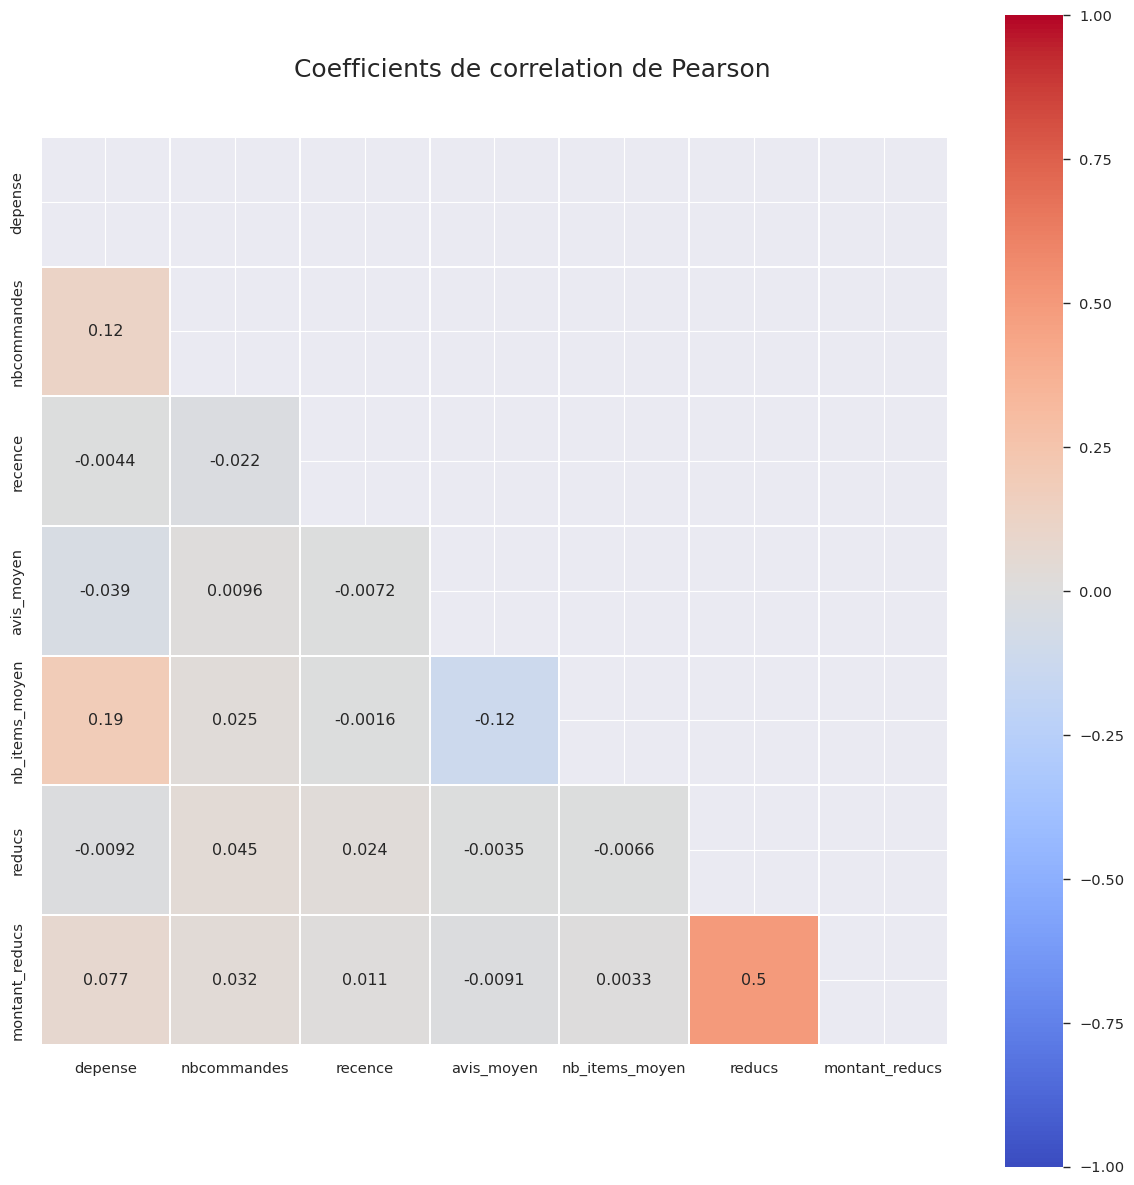

In [16]:
dfl = sdf[['depense', 'nbcommandes', 'recence', 'avis_moyen', 'nb_items_moyen', 'reducs', 'montant_reducs']]


sns.set(context="paper", font_scale = 1.2)

# compute the correlation matrix for all the numeric columns
corrmat = dfl.corr()

# Mask for upper triangle
mask = np.triu(np.ones_like(corrmat, dtype=bool))

# size of the plot
f, ax = plt.subplots(figsize=(12, 12))
# set the plot heading
f.text(0.45, 0.93, "Coefficients de correlation de Pearson", ha='center', fontsize = 18)
# plot matrix as a heatmap :
# --------------------------
# Note post-soutenance : Important de faire apparaitre les valeurs des coefficients et de mettre une echelle entre -1 et 1
sns.heatmap(corrmat, mask=mask, square=True, linewidths=0.01, cmap="coolwarm", annot=True, vmin=-1, vmax=1, center= 0)
plt.tight_layout()

On a quelques variables logiquement correllees.

# 2. Partitionnement

In [17]:
df_big = sdf.drop(columns=['client', 'categorie_produit_preferee'])
X = df_big
X_scaled = StandardScaler().fit_transform(X)

In [18]:
X.head(2)

depense  nbcommandes  recence  avis_moyen  nb_items_moyen  reducs  \
0   141.90            1      111         5.0             1.0     0.0   
1    27.19            1      114         4.0             1.0     0.0   

   montant_reducs  
0             0.0  
1             0.0

## 2.1. K-means, incluant l'usage des _vouchers_

### 2.1.1. Métrique d'inertie

Inertie fait référence à l'inertie intra-classe, à savoir la variabilité/la distance entre des points appartenant à un même cluster.

In [19]:
inertia_lst_bigdf = []
k_list_1 = range(1, 10)

for i in k_list_1 :
    model = KMeans(n_init = KMEANS_NINIT, n_clusters=i, random_state=KMEANS_RANDSTATE)
    model.fit(X)
    inertia_lst_bigdf.append(model.inertia_)

### 2.1.2. Métrique de silhouette

La silhouette met en rapport l'inertie intra-classe avec la distance entre les points de clusters différents. Elle offre donc une métrique plus globale pour le modèle. Mais son calcul est bien plus consommateur de ressources.

In [20]:
silhouette_score_lst_bigds = []
k_list_2 = range(2, 10)

for i in k_list_2 : 
    model = KMeans(n_init = KMEANS_NINIT, n_clusters=i, random_state=KMEANS_RANDSTATE)
    model.fit(X_scaled)
    df_big.loc[:, f'k{i}_labels'] = model.predict(X_scaled)
    silhouette_score_lst_bigds.append(silhouette_score(X_scaled, df_big[f'k{i}_labels']))

### 2.1.3. Représentation graphique de l'évolution des métriques

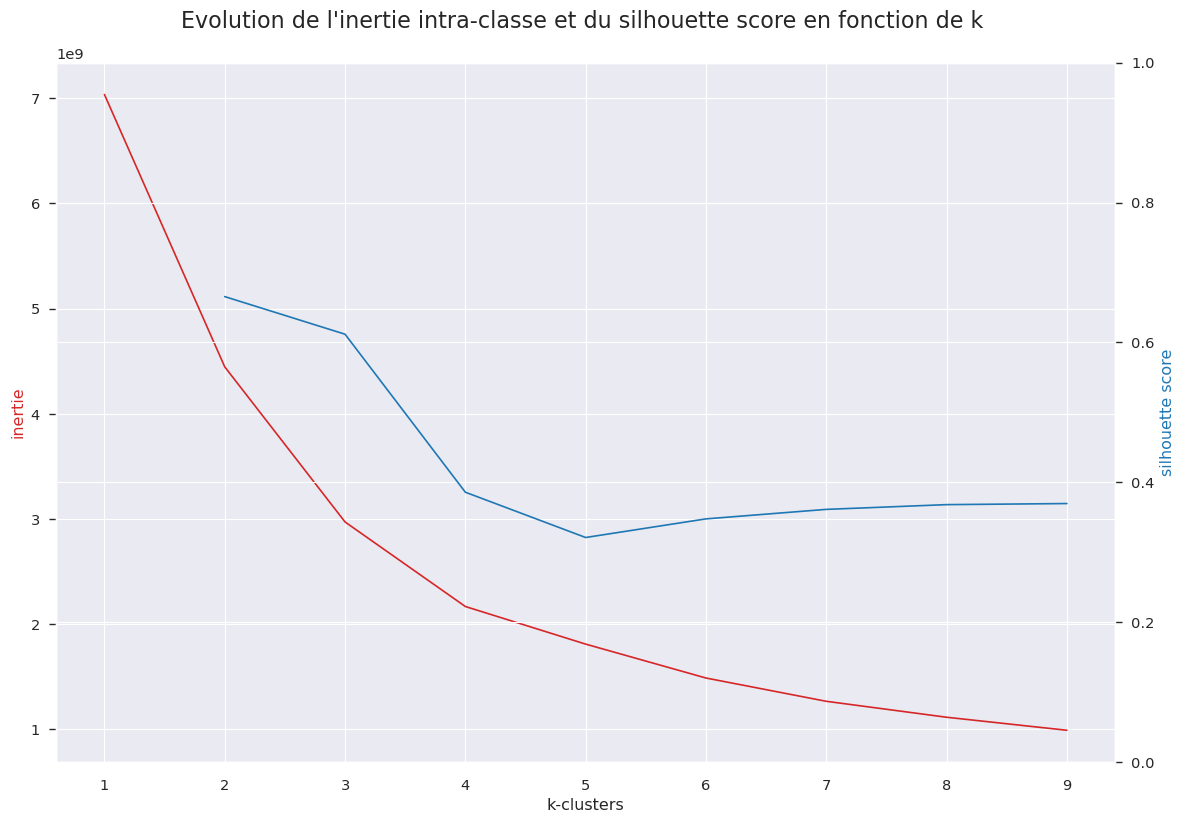

In [21]:
fig, ax1 = plt.subplots()
fig.set_figheight(8)
fig.set_figwidth(12)

color = 'tab:red'
ax1.set_xlabel('k-clusters')
ax1.set_ylabel('inertie', color=color) 
ax1.plot(k_list_1, inertia_lst_bigdf, color=color)
ax1.tick_params(axis='y') # , labelcolor=color # Pas envie d'avoir l'echelle en rouge

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('silhouette score', color=color)  # we already handled the x-label with ax1
ax2.plot(k_list_2, silhouette_score_lst_bigds, color=color)
ax2.tick_params(axis='y')
ax2.set_ylim(0, 1)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title("Evolution de l'inertie intra-classe et du silhouette score en fonction de k \n", fontsize = 16)
plt.show()

In [22]:
print(f"Notre inertie intraclasse diminue de {np.round(((inertia_lst_bigdf[1]-inertia_lst_bigdf[2])/inertia_lst_bigdf[1])*100, 2)}% entre k=2 et k=3")
print(f"Notre inertie intraclasse diminue de {np.round(((inertia_lst_bigdf[1]-inertia_lst_bigdf[3])/inertia_lst_bigdf[1])*100, 2)}% entre k=2 et k=4")

Notre inertie intraclasse diminue de 33.16% entre k=2 et k=3
Notre inertie intraclasse diminue de 51.23% entre k=2 et k=4


In [23]:
print(f"Notre silhouette diminue de {np.round(((max(silhouette_score_lst_bigds)-silhouette_score_lst_bigds[1])/max(silhouette_score_lst_bigds))*100, 2)}% entre k=2 et k=3")
print(f"Notre silhouette diminue de {np.round(((max(silhouette_score_lst_bigds)-silhouette_score_lst_bigds[2])/max(silhouette_score_lst_bigds))*100, 2)}% entre k=2 et k=4")

Notre silhouette diminue de 8.08% entre k=2 et k=3
Notre silhouette diminue de 42.03% entre k=2 et k=4


k = 2 donne la meilleures silhouette. Cependant, vu l'ACP, on risque simplement de disintguer deux groupes assez faciles : soit les MVC (_Most Valuable Customers_) et les autres. Soit les clients récents et les plus anciens.

k = 4 semble etre un bon compromis. On maintient un score de silhouette superieur a 0.4 tout en diminuant notre inertie intra-classe de 10**9

### 2.1.4. Modélisation pour différentes valeurs

L'objectif ici est de modéliser nos clusters pour certaines valeurs choisies de k, puis d'en sauvegarder les résultats, pour réaliser une analyse dans le chapitre suivant.

#### 2.1.4.1. k=3

In [24]:
model = KMeans(n_init = KMEANS_NINIT, n_clusters=3, random_state=KMEANS_RANDSTATE)
model.fit(X_scaled)
df_big.loc[:, 'k3_labels'] = model.predict(X_scaled)
df_big['k3_labels'].value_counts(normalize=True)

k3_labels
0    0.949271
1    0.029114
2    0.021616
Name: proportion, dtype: float64

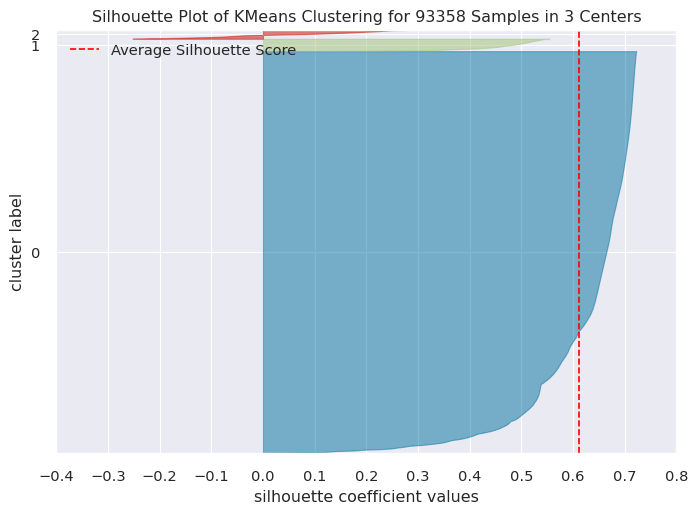

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 93358 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [25]:
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
visualizer.fit(X_scaled)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

1 dispose de pas mal d'outliers, et trois ressemble à un gros ventre mou.

In [26]:
df_big.groupby('k3_labels').mean()

depense  nbcommandes     recence  avis_moyen  nb_items_moyen  \
k3_labels                                                                    
0          159.718889     1.000000  237.072228     4.15952        1.137189   
1          332.163907     2.111479  218.955114     4.21718        1.219631   
2          180.959529     1.049058  255.438553     4.05963        1.134457   

             reducs  montant_reducs  k2_labels  k4_labels  k5_labels  \
k3_labels                                                              
0          0.016328        0.633966   0.999515   0.218163   1.074316   
1          0.058131        3.016225   0.969463   2.995585   2.005151   
2          1.926660      138.073221   0.000000   1.910307   2.869177   

           k6_labels  k7_labels  k8_labels  k9_labels  
k3_labels                                              
0           1.576031   1.440015   2.141127   2.425165  
1           1.057395   3.027594   3.069536   3.063650  
2           3.795342   3.807730   2.136769   6.020813

Vraiment pas très intéressant comme segmentation :
- 0 : Les clients lambda.
- 1 : Les clients reguliers
- 2 : Les fannas de reduction

#### 2.1.4.2. k=4

In [27]:
model = KMeans(n_init = KMEANS_NINIT, n_clusters=4, random_state=KMEANS_RANDSTATE)
model.fit(X_scaled)
df_big.loc[:, 'k4_labels'] = model.predict(X_scaled)
df_big['k4_labels'].value_counts(normalize=True)

k4_labels
0    0.742925
1    0.207620
3    0.029071
2    0.020384
Name: proportion, dtype: float64

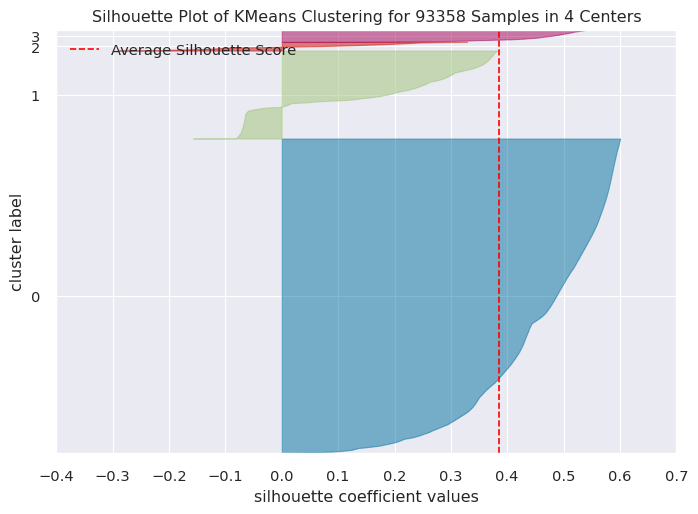

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 93358 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [28]:
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
visualizer.fit(X_scaled)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

1 & 2 disposent de pas mal d'outliers.

In [29]:
# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(X_scaled, df_big['k4_labels'])

In [30]:
df_big.groupby('k4_labels').mean()

depense  nbcommandes     recence  avis_moyen  nb_items_moyen  \
k4_labels                                                                    
0          151.636945     1.000000  236.303829    4.753871        1.075737   
1          189.868711     1.000000  239.952226    2.028943        1.357375   
2          185.836206     1.050972  254.895954    4.091084        1.135751   
3          321.112181     2.113854  219.155490    4.218237        1.216639   

             reducs  montant_reducs  k2_labels  k3_labels  k5_labels  \
k4_labels                                                              
0          0.017475        0.708070   0.998501   0.002019   0.578448   
1          0.018263        0.768996   0.997317   0.004746   2.852861   
2          1.978981      142.193642   0.000000   2.000000   2.943248   
3          0.059322        3.096146   0.968681   1.000737   2.000737   

           k6_labels  k7_labels  k8_labels  k9_labels  
k4_labels                                              
0           1.215029   0.686251   2.234220   2.860261  
1           2.869473   4.142238   1.808905   0.890471  
2           3.923805   3.912244   2.142932   6.022596  
3           1.048637   3.021002   3.060059   3.057111

Rappels : Panier moyen global = 160 / Panier moyen clients reguliers = 146

La clusterisation est assez simple :
- Un groupe est plutot satisfait qui consomme a peine moins que le panier moyen. (74%)
- Un groupe plutot peu satisfait qui consomme un peu plus que le panier moyen (20%)
- Un groupe satisfait, mais qui utilise beaucoup de reductions. (2%)
- On retrouve nos MVC (_Most Valuable Customers_) (3%)

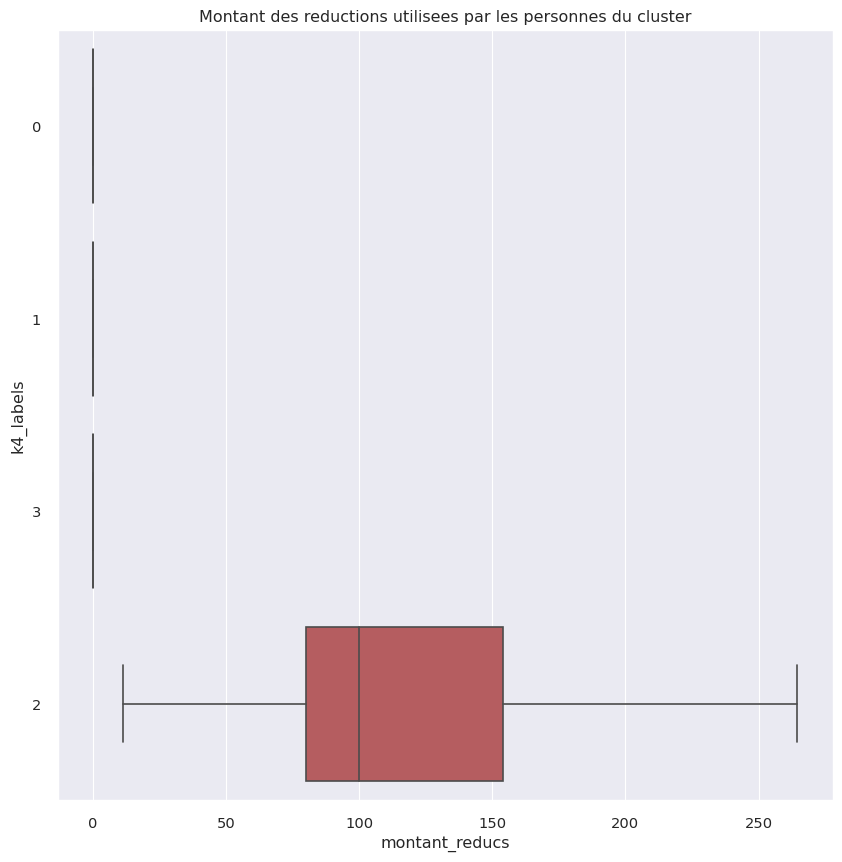

In [31]:
cv810.boxplot_numfeature(df = df_big, feature = 'montant_reducs', label = 'k4_labels', viz_outliers = False, titre = "Montant des reductions utilisees par les personnes du cluster")

Médiane du montant des réductions a 100 R$, soit à peu près les deux tiers du panier moyen.

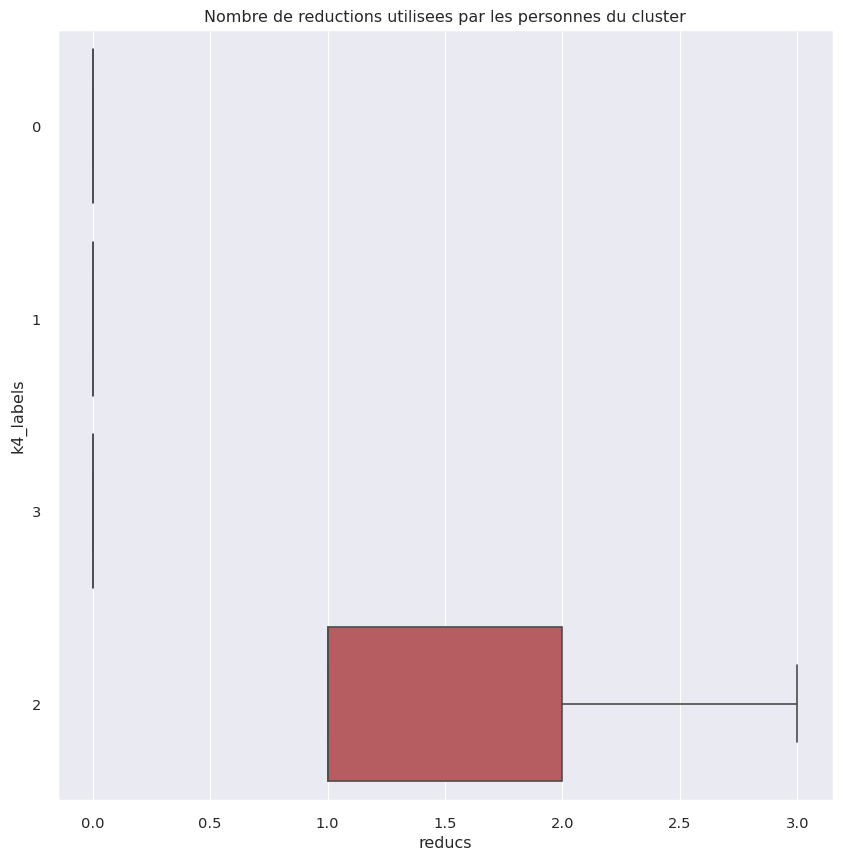

In [32]:
cv810.boxplot_numfeature(df = df_big, feature = 'reducs', label = 'k4_labels', viz_outliers = False, titre = "Nombre de reductions utilisees par les personnes du cluster")

La cluster des fans de réducs est assez unique.

N.B : Parmis les membres des autres clusters, certains utilisent des réductions ou des cartes cadeaux. 

Pour étudier plus en détails l'influence des autres features, nous allons donc travailler sur un dataframe plus réduit.

##### Sauvegarde des outliers.

In [33]:
clients = sdf['client']
s_is = pd.DataFrame(sample_silhouette_values, columns=['silh_coef'])
labels = df_big['k4_labels']
silhouette_synth = pd.concat([clients, s_is, labels], axis=1)
silhouette_synth.head(2)

client  silh_coef  k4_labels
0  0000366f3b9a7992bf8c76cfdf3221e2   0.564256          0
1  0000b849f77a49e4a4ce2b2a4ca5be3f   0.401652          0

In [34]:
print("Nombre de clients total : ", silhouette_synth.shape[0])
print("Nombre de clients du cluster 1 : ", silhouette_synth[silhouette_synth['k4_labels'] == 1].shape[0])

Nombre de clients total :  93358
Nombre de clients du cluster 1 :  19383


In [35]:
outliers_dfbig_k4 = silhouette_synth[silhouette_synth['silh_coef'] < 0]

#### Sauvegarder les résultats du modele

In [36]:
df_tosave.loc[:, 'big_k4_label'] = df_big['k4_labels']
df_tosave.loc[:, 'outliers_dfbig_k4'] = 0
df_tosave.loc[df_tosave['client'].isin(outliers_dfbig_k4['client'].tolist()), 'outliers_dfbig_k4'] = 1

In [37]:
df_tosave[df_tosave['outliers_dfbig_k4'] == 1].shape

(7906, 11)

## 2.2. K-means, RFM + avis + nbProduits

Dans les modèles qui vont suivre, on ne prendra plus en considération les features liées aux _vouchers_. Ainsi l'inertie intraclasse pourra réduire drastiquement, puisque nous aurons deux dimensions de moins à prendre en compte dans le calcul de nos distances.

In [38]:
df_small = sdf.drop(columns=['client', 'categorie_produit_preferee', 'reducs', 'montant_reducs'])

In [39]:
df_small.head(2)

depense  nbcommandes  recence  avis_moyen  nb_items_moyen  big_k4_label  \
0   141.90            1      111         5.0             1.0             0   
1    27.19            1      114         4.0             1.0             0   

   outliers_dfbig_k4  
0                  0  
1                  0

Tout ce que le df_small a de plus qu'une simple RFM est qu'il inclus la satisfaction client et la quantité de produits par commandés.

In [40]:
df_small.shape

(93358, 7)

In [41]:
X = df_small[['depense', 'nbcommandes', 'recence', 'avis_moyen', 'nb_items_moyen']]
X_scaled = StandardScaler().fit_transform(X)
X.head(2)

depense  nbcommandes  recence  avis_moyen  nb_items_moyen
0   141.90            1      111         5.0             1.0
1    27.19            1      114         4.0             1.0

### 2.2.1. Métrique d'inertie

In [42]:
inertia_lst_smalldf = []
# Le coude arrive a peu pres a 6, mais on a test a 20
k_list_1 = range(1, 10)

for i in k_list_1 :
    model = KMeans(n_init = KMEANS_NINIT, n_clusters=i, random_state=KMEANS_RANDSTATE)
    model.fit(X_scaled)
    inertia_lst_smalldf.append(model.inertia_)


### 2.2.2. Métrique de silhouette

N.B : Le calcul du silhouette score est très consommateur en calcul. Le seul bloc ci-dessous prend environ 15 minutes. Une idée, venue suite au problème de modélisation en CAH, aurait été de travailler éventuellement avec un échantillon.

In [43]:
silhouette_lst_smalldf = []
# Le coude arrive a peu pres a 6, mais on a test a 20
k_list_2 = range(2, 10)

for i in k_list_2 :
    model = KMeans(n_init = KMEANS_NINIT, n_clusters=i, random_state=KMEANS_RANDSTATE)
    model.fit(X_scaled)
    df_small.loc[:, f'k{i}_labels'] = model.predict(X_scaled)
    silhouette_lst_smalldf.append(silhouette_score(X_scaled, df_small[f'k{i}_labels']))

### 2.2.3. Représentation graphique des métriques en fonction de k

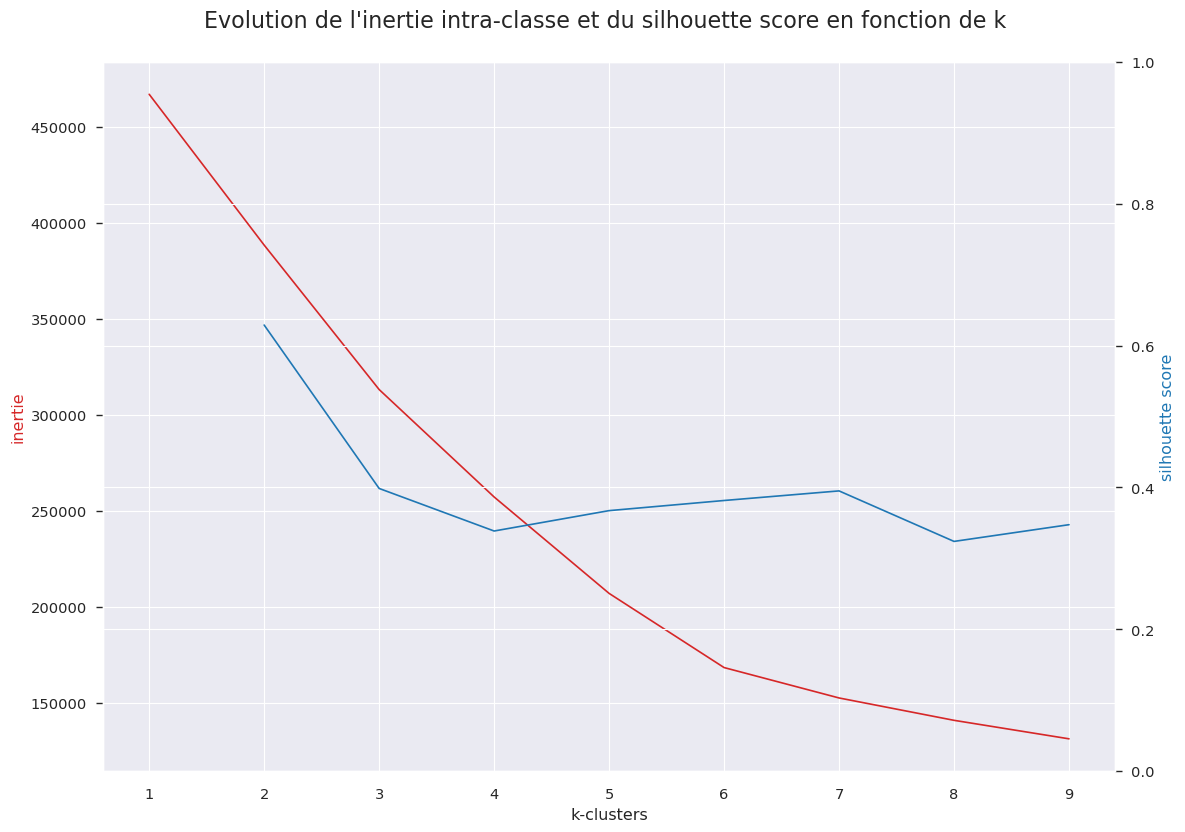

In [44]:
fig, ax1 = plt.subplots()
fig.set_figheight(8)
fig.set_figwidth(12)

color = 'tab:red'
ax1.set_xlabel('k-clusters')
ax1.set_ylabel('inertie', color=color) 
ax1.plot(k_list_1, inertia_lst_smalldf, color=color)
ax1.tick_params(axis='y') # , labelcolor=color # Pas envie d'avoir l'echelle en rouge

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('silhouette score', color=color)  # we already handled the x-label with ax1
ax2.plot(k_list_2, silhouette_lst_smalldf, color=color)
ax2.tick_params(axis='y')
ax2.set_ylim(0, 1)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title("Evolution de l'inertie intra-classe et du silhouette score en fonction de k \n", fontsize = 16)
plt.show()

In [45]:
print(f"Notre inertie intraclasse diminue de {np.round(((inertia_lst_smalldf[1]-inertia_lst_smalldf[6])/inertia_lst_smalldf[1])*100, 2)}% entre k=3 et k=8")

Notre inertie intraclasse diminue de 60.69% entre k=3 et k=8


In [46]:
print(f"Notre silhouette diminue de {np.round(((max(silhouette_lst_smalldf)-silhouette_lst_smalldf[6])/max(silhouette_lst_smalldf))*100, 2)}% entre k=3 et k=8")

Notre silhouette diminue de 48.51% entre k=3 et k=8


k = 6 est là où apparait le coude de la courbe d'inertie.

Cependant, le silhouette score de k = 7 est supérieur à celui de k = 6, pour une inertie intra-classe encore plus faible. Il semble donc pertinent de préférer k=7.

Sur la base du silhouette score, k = 2 aurait été la meilleure solution, mais nos clusters n'auraient alors pas apporté beaucoup d'informations au _business_.

Dans le chapitre suivant, nous étudierons seulement k=7 (dans des versions de travail, nous avons etudie differentes clusterisations, mais elles n'apportent que peu d'informations).

### 2.2.3. Étude de modèles specifiques

In [47]:
model = KMeans(n_init = KMEANS_NINIT, n_clusters=7, random_state=KMEANS_RANDSTATE)
model.fit(X_scaled)
df_small.loc[:, 'k7_labels'] = model.predict(X_scaled)
df_small['k7_labels'].value_counts(normalize=True)

k7_labels
0    0.412798
2    0.311950
4    0.152542
5    0.065040
3    0.029521
6    0.019109
1    0.009040
Name: proportion, dtype: float64

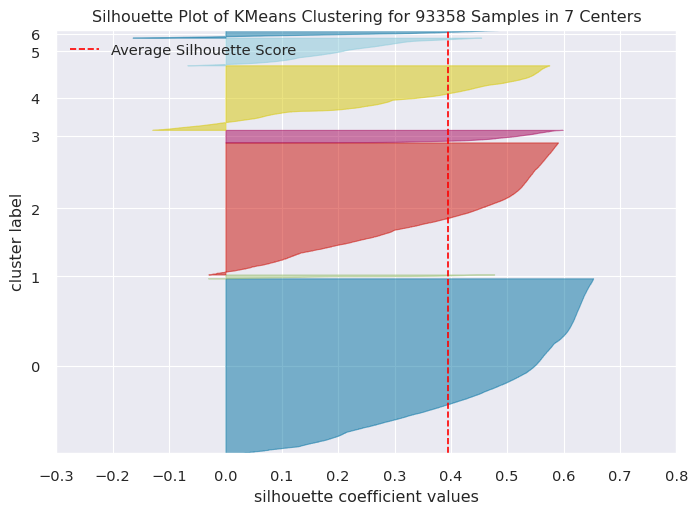

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 93358 Samples in 7 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [48]:
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
visualizer.fit(X_scaled)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

Certains de nos clusters disposent d'outliers, mais notre silhouette score moyen est légèrement supérieur à celui pour k=6, et atteint 0.4.

In [49]:
# Compute the silhouette scores for each sample
sample_silhouette_values_smdf_k7 = silhouette_samples(X_scaled, df_small['k7_labels'])

In [50]:
df_small.groupby('k7_labels').mean()

depense  nbcommandes     recence  avis_moyen  nb_items_moyen  \
k7_labels                                                                     
0           127.901221     1.000000  122.238985    4.697753        1.000000   
1           455.926836     1.024882  239.472749    3.348934        4.963863   
2           128.909708     1.000000  392.714796    4.642104        1.002610   
3           287.765962     2.115022  219.521771    4.217935        1.179895   
4           143.140353     1.000000  232.150270    1.679376        1.117267   
5           203.229463     1.000000  237.499506    4.323617        2.186594   
6          1283.046099     1.014574  233.892937    4.162276        1.131166   

           big_k4_label  outliers_dfbig_k4  k2_labels  k3_labels  k4_labels  \
k7_labels                                                                     
0              0.068685           0.041517   0.000000   0.033837   1.999766   
1              1.059242           0.263033   0.024882   0.851896   0.111374   
2              0.098891           0.065103   0.000000   0.056897   1.004120   
3              2.968070           0.013788   1.000000   2.000000   3.000000   
4              1.022470           0.254828   0.000000   1.000000   0.393441   
5              0.258070           0.056653   0.000000   0.214756   1.226120   
6              0.337444           0.099215   0.019058   0.262892   1.137332   

           k5_labels  k6_labels  k8_labels  k9_labels  
k7_labels                                              
0           3.006617   1.013779   3.525481   0.943588  
1           1.002370   3.988152   1.000000   5.011848  
2           0.016997   0.009031   3.949868   1.140885  
3           1.998186   4.999637   4.000000   2.003628  
4           3.996840   2.999930   2.041079   5.263184  
5           1.700264   1.404150   6.042325   3.975296  
6           1.537556   2.005605   3.004484   7.754484

_L'analyse détaillée des catégories sera realisée dans la section dédiée du NoteBook ou nous representerons les clusters avec des radars charts_

#### Récuperation des outliers

In [51]:
clients = sdf['client']
s_is = pd.DataFrame(sample_silhouette_values_smdf_k7, columns=['silh_coef'])
labels = df_small['k7_labels']
silhouette_synth = pd.concat([clients, s_is, labels], axis=1)
silhouette_synth.head(2)

client  silh_coef  k7_labels
0  0000366f3b9a7992bf8c76cfdf3221e2   0.630595          0
1  0000b849f77a49e4a4ce2b2a4ca5be3f   0.522545          0

In [52]:
silhouette_synth.loc[:, 'is_outlier'] = 0
silhouette_synth.loc[silhouette_synth['silh_coef'] < 0, 'is_outlier'] = 1
silhouette_synth.head(2)

client  silh_coef  k7_labels  is_outlier
0  0000366f3b9a7992bf8c76cfdf3221e2   0.630595          0           0
1  0000b849f77a49e4a4ce2b2a4ca5be3f   0.522545          0           0

In [53]:
silhouette_synth.drop(columns=['silh_coef'], inplace=True)
silhouette_synth[silhouette_synth['is_outlier'] == 1].shape

(2931, 3)

#### Sauvegarder les résultats du modèle

In [54]:
df_tosave = df_tosave.merge(silhouette_synth, on='client', how='left')
df_tosave.rename(columns={'k7_labels' : 'small_k7_label', 'is_outlier' : 'small_k7_is_outlier'}, inplace=True)
df_tosave.head(2)

client  depense  nbcommandes  recence  \
0  0000366f3b9a7992bf8c76cfdf3221e2   141.90            1      111   
1  0000b849f77a49e4a4ce2b2a4ca5be3f    27.19            1      114   

   avis_moyen  nb_items_moyen  reducs  montant_reducs  \
0         5.0             1.0     0.0             0.0   
1         4.0             1.0     0.0             0.0   

  categorie_produit_preferee  big_k4_label  outliers_dfbig_k4  small_k7_label  \
0             bed_bath_table             0                  0               0   
1              health_beauty             0                  0               0   

   small_k7_is_outlier  
0                    0  
1                    0

## Sauvegarde des résultats.

Les calculs liés au score de silhouette étant très consommateurs, on va éviter au maximum d'avoir à les reproduire.

In [55]:
date_of_birth = dt.date.today()
df_tosave.to_csv('./model_results/kmeans_'+date_of_birth.strftime("%Y%m%d")+'.csv', index=False)

# Synthese K-means

Nous avons travaillé sur deux types de données d'entrées distinctes : 
1. Le premier dataframe, dit "big", inclus l'usage ou non de bons réduction (_voucher_), ainsi que le montant associé à ces derniers
2. Le second dataframe, dit "small", n'inclus pas l'usage de bons. C'est peu ou prou une RFM à laquelle on ajoute le score de satisfaction moyen et la quantité de produits commandés.

- Dans le cas1, le nombre de clusters nous paraissant offrir un bon compromis entre inertie-intraclasse et silhouette est de 4. L'analyse des catégories met effectivement en valeur une catégorie de personnes dont les pratiques de consommation reposent sur l'usage de bons de reduction.
- Dans le cas2, le nombre de clusters nous paraissant offrir un bon compromis entre inertie-intraclasse et silhouette est de 7. L'analyse des categories va effectivement légèrement plus loin que l'analyse RFM puisqu'elle inclus un score de satisfaction. En prenant en compte ce score, on peut mieux orienter nos messages et éviter de réactiver de la même manière un client qui fut très satisfait, d'un qui ne l'est pas. 

Comme le business model ne repose pas nécessairement sur la fidélisation, peut-être peut-on simplement faire l'effort de réactiver les primo-acheteurs récents qui furent satisfaits de leur expérience. En espérant qu'ils deviennent des clients réguliers.


# Analyse détaillée des segments

In [57]:
df = pd.read_csv('./model_results/kmeans_20230818.csv')
df.head(2)

client  depense  nbcommandes  recence  \
0  0000366f3b9a7992bf8c76cfdf3221e2   141.90            1      111   
1  0000b849f77a49e4a4ce2b2a4ca5be3f    27.19            1      114   

   avis_moyen  nb_items_moyen  reducs  montant_reducs  \
0         5.0             1.0     0.0             0.0   
1         4.0             1.0     0.0             0.0   

  categorie_produit_preferee  big_k4_label  outliers_dfbig_k4  small_k7_label  \
0             bed_bath_table             0                  0               0   
1              health_beauty             0                  0               0   

   small_k7_is_outlier  
0                    0  
1                    0

## 1. Préparation : Note par feature pour Radar Charts

Afin de pouvoir réaliser des radars charts, on va représenter les valeurs de nos observation par une note entre 0 et 5 pour chacune de nos features.

### 1.1. Récence

In [58]:
df['segments_Recence'] = pd.qcut(df['recence'], 6)
df['note_Recence'] = pd.qcut(df['recence'], 6, labels=False)
df['segments_Recence'].value_counts()

segments_Recence
(75.0, 148.0]     15738
(-0.001, 75.0]    15597
(218.0, 289.0]    15542
(148.0, 218.0]    15512
(406.0, 713.0]    15510
(289.0, 406.0]    15459
Name: count, dtype: int64

In [59]:
df['note_Recence'].value_counts()

note_Recence
1    15738
0    15597
3    15542
2    15512
5    15510
4    15459
Name: count, dtype: int64

On va faire en sorte que la meilleure note corresponde aux commandes les plus récentes. Il est plus simple de partir du principe que la note la plus élevée est la meilleure.

In [60]:
df.loc[df['note_Recence']==0, 'radar_Recence'] = 5
df.loc[df['note_Recence']==1, 'radar_Recence'] = 4
df.loc[df['note_Recence']==2, 'radar_Recence'] = 3
df.loc[df['note_Recence']==3, 'radar_Recence'] = 2
df.loc[df['note_Recence']==4, 'radar_Recence'] = 1
df.loc[df['note_Recence']==5, 'radar_Recence'] = 0
df['radar_Recence'].value_counts()

radar_Recence
4.0    15738
5.0    15597
2.0    15542
3.0    15512
0.0    15510
1.0    15459
Name: count, dtype: int64

### 1.2. Dépenses

In [61]:
df['segments_Depense'] = pd.qcut(df['depense'], 6)
df['note_Depense'] = pd.qcut(df['depense'], 6, labels=False)
df['segments_Depense'].value_counts()

segments_Depense
(9.589, 50.1]         15582
(151.78, 231.27]      15579
(50.1, 75.17]         15568
(107.78, 151.78]      15561
(231.27, 13664.08]    15538
(75.17, 107.78]       15530
Name: count, dtype: int64

### 1.3. Avis

Pas de transformation nécessaire, puisque déjà entre 0 et 5.

### 1.4. Nb items par commande

Trop peu de disparité dans les commandes pour faire des qcuts. Je vais établir d'une notation moi-même en fonction de la distribution de cette variable.

In [62]:
df['note_nbItems'] = 1
df.loc[df['nb_items_moyen']==2, 'note_nbItems'] = 3
df.loc[df['nb_items_moyen']>2, 'note_nbItems'] = 5
df['note_nbItems'].value_counts()

note_nbItems
1    84308
3     6954
5     2096
Name: count, dtype: int64

### 1.5. Nb commandes

In [63]:
df['note_nbCommandes'] = 1
df.loc[df['nbcommandes']>1, 'note_nbCommandes'] = 5
df['note_nbCommandes'].value_counts()

note_nbCommandes
1    90557
5     2801
Name: count, dtype: int64

### 1.6. Nombre de réducs et montants réducs

#### Nombre de réducs

In [64]:
df['reducs'].value_counts().head(3)

reducs
0.0    89767
1.0     2787
2.0      444
Name: count, dtype: int64

Distribution très inégale des réductions.

In [65]:
df['note_nbReducs'] = 0
df.loc[df['reducs'] == 1, 'note_nbReducs'] = 2
df.loc[df['reducs'] > 1, 'note_nbReducs'] = 5
df['note_nbReducs'].value_counts()

note_nbReducs
0    89767
2     2787
5      804
Name: count, dtype: int64

#### Montant des réducs

In [66]:
df['note_montantReducs'] = 0
df.loc[(df['montant_reducs'] > 0) & (df['montant_reducs'] < 100), 'note_montantReducs'] = 2
df.loc[(df['montant_reducs'] > 0) & (df['montant_reducs'] >= 100), 'note_montantReducs'] = 5
df['note_montantReducs'].value_counts()

note_montantReducs
0    89767
2     2430
5     1161
Name: count, dtype: int64

### 1.7. Synthèse radar

In [69]:
radar_df = df[['radar_Recence', 'note_Depense', 'avis_moyen', 'note_nbItems', 'note_nbCommandes', 'note_montantReducs', 'big_k4_label', 'outliers_dfbig_k4', 'small_k7_label']]
radar_df.head(2)

radar_Recence  note_Depense  avis_moyen  note_nbItems  note_nbCommandes  \
0            4.0             3         5.0             1                 1   
1            4.0             0         4.0             1                 1   

   note_montantReducs  big_k4_label  outliers_dfbig_k4  small_k7_label  
0                   0             0                  0               0  
1                   0             0                  0               0

In [70]:
radar_df.rename(columns={'radar_Recence' : 'recence', 'note_Depense' : 'depenses', 
                         'avis_moyen' : 'Avis', 'note_nbItems' : 'Nb items', 
                         'note_nbCommandes' : 'nb commandes', 'note_montantReducs' : 'Reducs'}, inplace=True)

/tmp/ipykernel_21982/1344368512.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  radar_df.rename(columns={'radar_Recence' : 'recence', 'note_Depense' : 'depenses',


## 2. Analyse des clusters
### 2.1. k=4, Dataframe incluant les réductions

On va faire un focus sur le cluster 1 qui définit les usagers de _vouchers_.

In [77]:
radar_k4_c1 = radar_df[radar_df['big_k4_label'] == 2].drop(columns=['big_k4_label', 'small_k7_label', 'outliers_dfbig_k4'])
radar_k4_not_c1 = radar_df[radar_df['big_k4_label'] != 2].drop(columns=['big_k4_label','small_k7_label', 'outliers_dfbig_k4'])

In [78]:
rk4c1 = radar_k4_c1.mean().reset_index()
rk4c1.columns

Index(['index', 0], dtype='object')

In [79]:
rk4nc1 = radar_k4_not_c1.mean().reset_index()
rk4nc1.columns

Index(['index', 0], dtype='object')

Radar charts : 
[help](https://plotly.com/python/radar-chart/)

In [80]:
categories = rk4c1['index']

fig = go.Figure()

fig.add_trace(go.Scatterpolar(
      r=rk4c1[0],
      theta=categories,
      fill='toself',
      name='Cluster 2'
))

fig.add_trace(go.Scatterpolar(
      r=rk4nc1[0],
      theta=categories,
      fill='toself',
      name='Non cluster 2'
))

fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=[0, 5]
    ),
  ),
  showlegend=True
)

fig.show()

Le cluster 2 correspond bien a une catégorie de couponneurs : Ils ou elles dépensent à peine plus que le client lambda, auquel il ressemble en tout point, si ce n'est que le cluster 2 a un usage régulier des réductions.

#### Focus outliers.

In [82]:
radar_k4_c1 = radar_df[radar_df['big_k4_label'] == 2].drop(columns=['big_k4_label', 'small_k7_label'])
radar_k4_c1_ol = radar_k4_c1[radar_k4_c1['outliers_dfbig_k4'] == 1].drop(columns=['outliers_dfbig_k4'])
radar_k4_c1_nol = radar_k4_c1[radar_k4_c1['outliers_dfbig_k4'] != 1].drop(columns=['outliers_dfbig_k4'])

rk4c1_ol = radar_k4_c1_ol.mean().reset_index()
rk4c1_nol = radar_k4_c1_nol.mean().reset_index()

categories = rk4c1_ol['index']

fig = go.Figure()

fig.add_trace(go.Scatterpolar(
      r=rk4c1_ol[0],
      theta=categories,
      fill='toself',
      name='Outliers Cluster 2'
))

fig.add_trace(go.Scatterpolar(
      r=rk4c1_nol[0],
      theta=categories,
      fill='toself',
      name='Valid Cluster 2'
))

fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=[0, 5]
    ),
  ),
  showlegend=True
)

fig.show()

Les points qui apparaissaient comme des outliers (cf. la silhouette plot) disposent de la particularité suivante :
- Ils depensent en moyenne moins que les autres membres du cluster 2
- Ils utilisent moins de reductions

Ce cluster reposant sur l'utilisation de _vouchers_, on peut comprendre pourquoi une groupe d'individus qui en utilise finalement assez peu en quantité apparait comme eventuellement mal classé.

In [84]:
print(f"Part de couponneurs : {np.round((df[df['big_k4_label'] == 2].shape[0]/df.shape[0])*100, 2)}")

Part de couponneurs : 2.04


Les membres du cluster 2 peuvent être qualifiés de "couponneurs" ou de "fans de reduc's". Les outliers de ce cluster, sur la base du coefficient de silhouette, n'ont rien de vraiment particulier. C'est ce qui induit leur appartenance éventuelle à d'autres clusters. Ils dépensent moins que la moyenne générale, mais sont plutôt dans la moyenne pour tout le reste. Si ce n'est qu'ils utilisent des _vouchers_. Ils constituent une part de petits acheteurs qui n'investissent que motivés par une réduction éventuelle.

A ce cluster fut associé un de nos clients reguliers.

Si le client le demandait, on pourrait faire une analyse approfondie des profils de personnes appartenant à ce cluster, ou encore détailler si les _vouchers_ utilisés sont de types "carte cadeau" (montant entier) ou bon de reduction (montant réel, car pourcentage _off_)

# 7-Means

In [85]:
df['small_k7_label'].value_counts(normalize=True)

small_k7_label
0    0.412798
2    0.311950
4    0.152542
5    0.065040
3    0.029521
6    0.019109
1    0.009040
Name: proportion, dtype: float64

In [86]:
df[['depense', 'nbcommandes', 'recence', 'avis_moyen', 'nb_items_moyen', 'small_k7_label']].groupby('small_k7_label').mean() # One ne va pas considerer les reducs car elles n'entraient pas en compte dans le classement

depense  nbcommandes     recence  avis_moyen  \
small_k7_label                                                     
0                127.901221     1.000000  122.238985    4.697753   
1                455.926836     1.024882  239.472749    3.348934   
2                128.909708     1.000000  392.714796    4.642104   
3                287.765962     2.115022  219.521771    4.217935   
4                143.140353     1.000000  232.150270    1.679376   
5                203.229463     1.000000  237.499506    4.323617   
6               1283.046099     1.014574  233.892937    4.162276   

                nb_items_moyen  
small_k7_label                  
0                     1.000000  
1                     4.963863  
2                     1.002610  
3                     1.179895  
4                     1.117267  
5                     2.186594  
6                     1.131166

Rappels : Panier moyen global = 160 / Panier moyen clients reguliers = 146

- __k7_labels=0__ : Dépense assez peu, sont assez recent et tres satisfait. __A reactiver__(41%)
- __k7_labels=1__ : Ils et elles dépensent beaucoup, mais c'est parce qu'ils et elles achètent beaucoup d'articles. Leur satisfaction générale est plus faible que celle des clients lambda __'Gros paniers'__(0.9%)
- __k7_labels=2__ : Depense assez peu, mais est tres satisfait. Ces clients ont achete il y a longtemps __'Masse passee contentee'__. (31%)
- __k7_labels=3__ : Nos fameux clients récurrents, plutot satisfaits __M.V.C__ (2.9%)
- __k7_labels=4__ : Dépense à peu près le panier moyen. N'est ni récent, ni vieux, par contre, ce groupe n'est pas du tout satisfait du service __'Masse mécontente'__ (15%)
- __k7_labels=5__ : Ils depensent plus que la moyenne, mais c'est parce qu'ils achetent en moyenne deux articles. __'Moyens Paniers'__ (6.5%)
- __k7_labels=6__ : Achètent des articles bien plus cher que le reste de nos clients. __'Fortuné.es'__ (1.9%)


In [87]:
tmp_df = df[['depense', 'nbcommandes', 'recence', 'avis_moyen', 'nb_items_moyen', 'small_k7_label']]
tmp_df.loc[:, 'catcusto'] = ''
tmp_df.loc[tmp_df['small_k7_label'] == 0, 'catcusto'] = 'A réactiver'
tmp_df.loc[tmp_df['small_k7_label'] == 1, 'catcusto'] = 'Gros paniers'
tmp_df.loc[tmp_df['small_k7_label'] == 2, 'catcusto'] = 'Masse passée contentée'
tmp_df.loc[tmp_df['small_k7_label'] == 3, 'catcusto'] = 'MVC'
tmp_df.loc[tmp_df['small_k7_label'] == 4, 'catcusto'] = 'Mécontents'
tmp_df.loc[tmp_df['small_k7_label'] == 5, 'catcusto'] = 'Moyens paniers'
tmp_df.loc[tmp_df['small_k7_label'] == 6, 'catcusto'] = 'Fortunés'

/tmp/ipykernel_21982/438988424.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



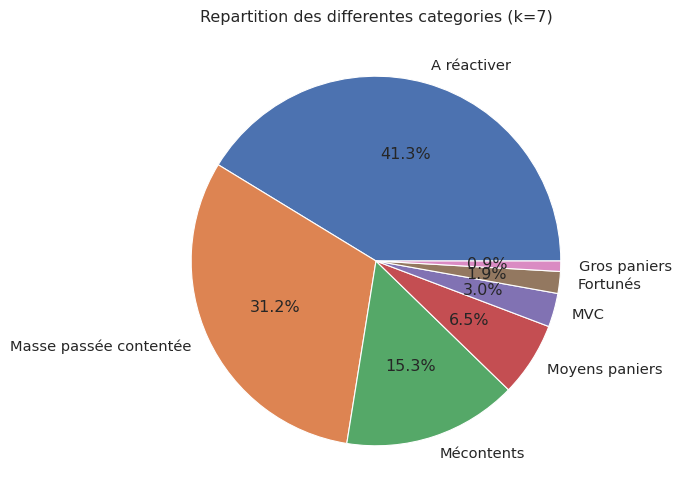

In [88]:
plt.figure(figsize=(8, 6))
plt.pie(x=tmp_df['catcusto'].value_counts(), labels=tmp_df['catcusto'].value_counts().index, autopct="%1.1f%%")
plt.title("Repartition des differentes categories (k=7)")
plt.show()

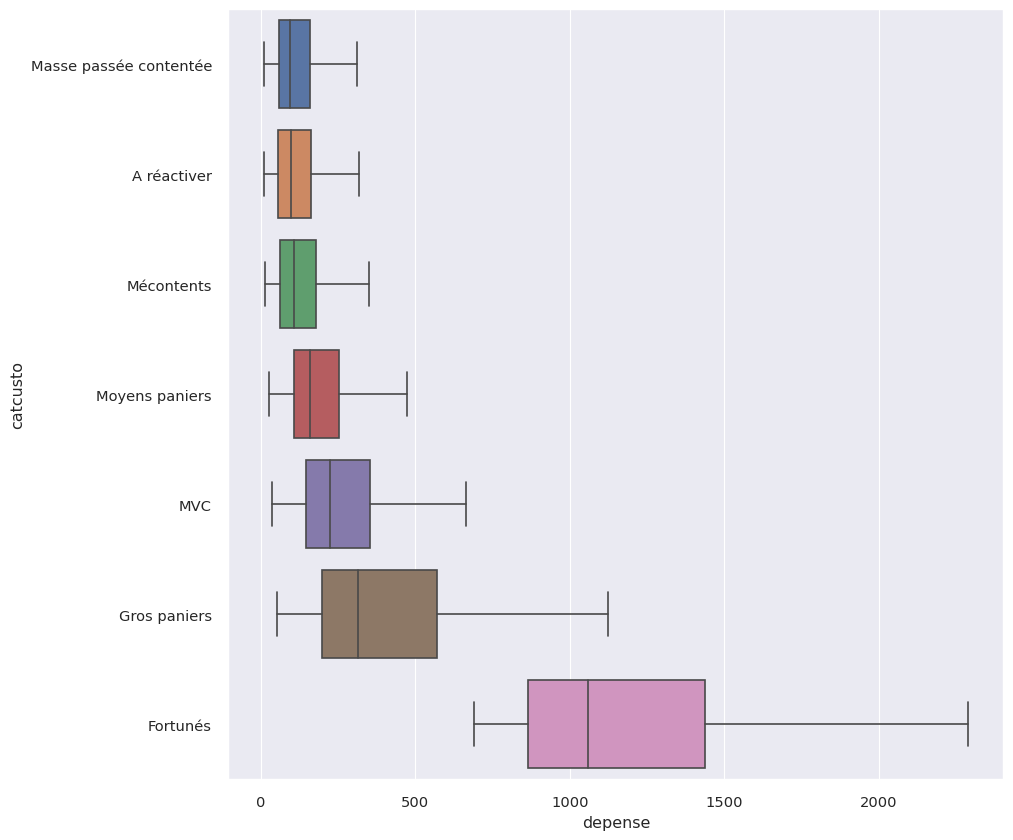

In [89]:
cv810.boxplot_numfeature(df=tmp_df, feature='depense', label='catcusto')

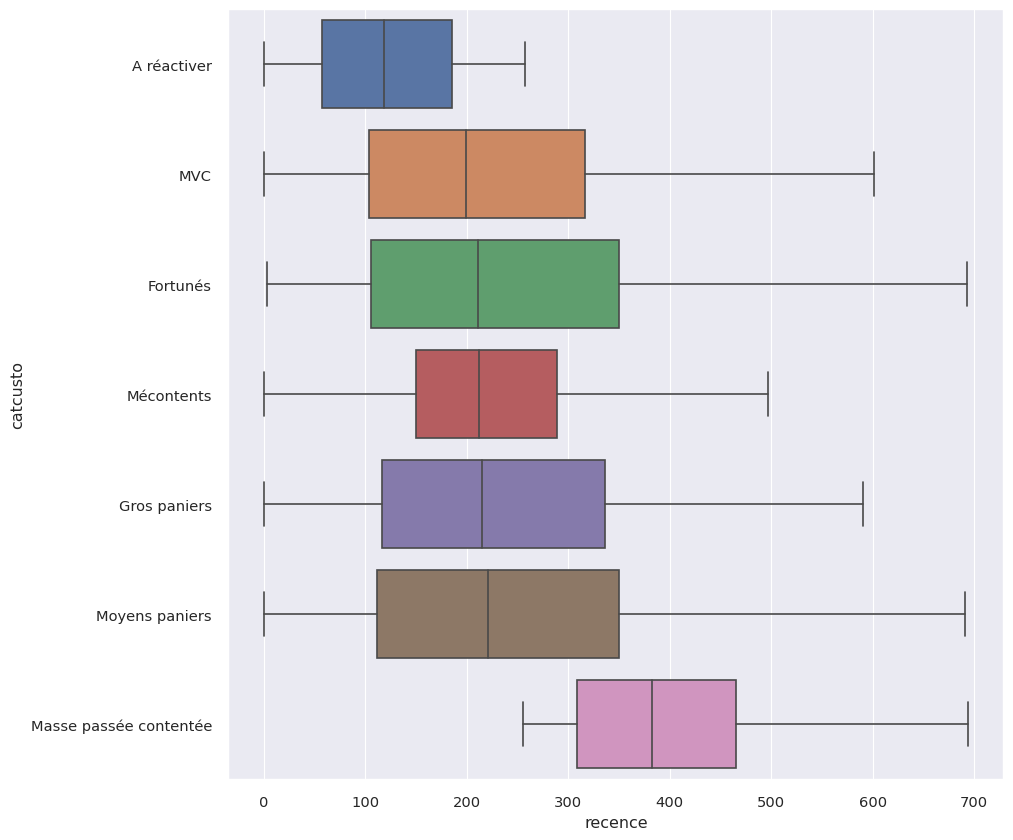

In [90]:
cv810.boxplot_numfeature(df=tmp_df, feature='recence', label='catcusto')

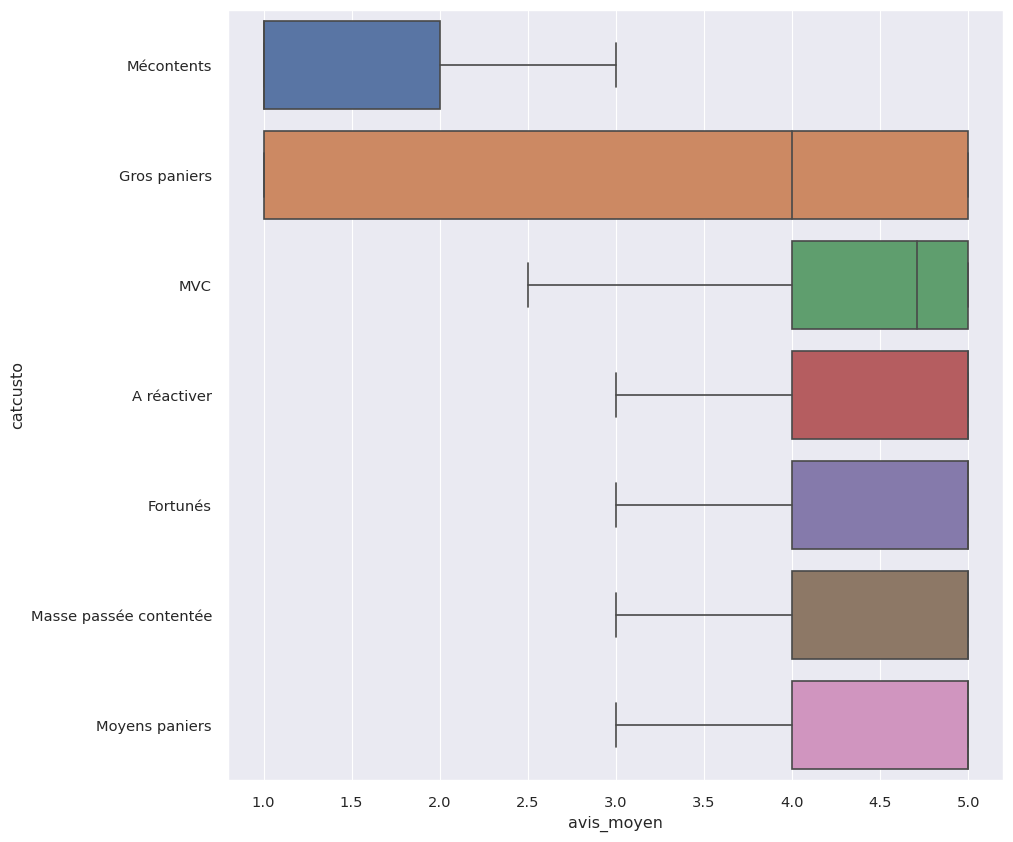

In [91]:
cv810.boxplot_numfeature(df=tmp_df, feature='avis_moyen', label='catcusto')

In [92]:
df['catcusto_k7s'] = tmp_df['catcusto']

In [93]:
date_of_birth = dt.date.today()
df.to_csv('./model_results/kmeans_'+date_of_birth.strftime("%Y%m%d")+'_labeled.csv', index=False)

# Synthese analyse K-Means

k=7 offre un détail intéressant relatif au pouvoir d'achat des clients, à leur satisfaction et à leur récence. Ces différentes catégories peuvent déjà permettre d'orienter les communications du clients pour envoyer le bon message à la bonne personne. 

__Perspectives d'amelioration :__
- Une information intéressante pourrait être de donner une valeur à chaque cluster en terme de montant dépensé pour le groupe. Cela permettrait d'estimer le poids réel des catégories les plus fortunées.

------------------------------------------------------------------------------------

# DBSCAN

## 1. Dataframe _avec_ les reductions
### 1.1. Recherche des meilleurs hyperparametres

Afin d'estimer une valeur d'epsilon adaptée à notre problème, nous alons d'abord utiliser un KNN pour obtenir un ordre de grandeur des distances entre les points pour un min_sample donné.

__Hypothèses :__ 
- Pour estimer ce min_sample, sur la base de nos K-Means précédents, on peut se dire qu'une categorie inférieure à 1% du dataset, n'a que peu d'intérêt. Le problème avec cette approche est qu'on explose notre temps de calcul. On a 100k observations. 1% du Dataset revient a 1k. Pour trouver notre Epsilon on va calculer, via un KNN, 1k distances pour 100k valeurs, soit 100M calculs.

In [3]:
df = pd.read_csv('./model_results/kmeans_20230818_labeled.csv')
df.head(2)

client  depense  nbcommandes  recence  \
0  0000366f3b9a7992bf8c76cfdf3221e2   141.90            1      111   
1  0000b849f77a49e4a4ce2b2a4ca5be3f    27.19            1      114   

   avis_moyen  nb_items_moyen  reducs  montant_reducs  \
0         5.0             1.0     0.0             0.0   
1         4.0             1.0     0.0             0.0   

  categorie_produit_preferee  big_k4_label  ...  segments_Recence  \
0             bed_bath_table             0  ...     (75.0, 148.0]   
1              health_beauty             0  ...     (75.0, 148.0]   

   note_Recence  radar_Recence  segments_Depense  note_Depense  note_nbItems  \
0             1            4.0  (107.78, 151.78]             3             1   
1             1            4.0     (9.589, 50.1]             0             1   

  note_nbCommandes  note_nbReducs  note_montantReducs  catcusto_k7s  
0                1              0                   0   A réactiver  
1                1              0                   0   A réactiver  

[2 rows x 23 columns]

In [4]:
dfwip_withreduc = df[['depense', 'nbcommandes', 'recence', 'avis_moyen', 'nb_items_moyen', 'reducs', 'montant_reducs']]

In [5]:
DB_MIN_SAMPLE = int(dfwip_withreduc.shape[0]*0.01) # 1% de nos observations
X = dfwip_withreduc.values
X_scaled = StandardScaler().fit_transform(X)

In [7]:
nghbrs = NearestNeighbors(n_neighbors=DB_MIN_SAMPLE).fit(X_scaled) # Helas, plus notre DB_MIN est grand, plus les temps de calculs sont longs
distances, indices = nghbrs.kneighbors(X_scaled)

In [8]:
print("min samples : ", DB_MIN_SAMPLE)
print("Shape of distance matrix : ", distances.shape)
# for enum, row in enumerate(distances[:5]) :
#     print("observation "+str(enum)+ " : " + str([round(x, 2) for x in row])) 

min samples :  933
Shape of distance matrix :  (93358, 933)


La dernière colonne de chaque ligne représente la distance du k-ieme point le plus éloigné.

In [9]:
dfwip_withreduc['knn_point_leplus_eloigne'] = distances[:, -1]
dfwip_withreduc.head(2)

/tmp/ipykernel_29532/1387759180.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfwip_withreduc['knn_point_leplus_eloigne'] = distances[:, -1]


depense  nbcommandes  recence  avis_moyen  nb_items_moyen  reducs  \
0   141.90            1      111         5.0             1.0     0.0   
1    27.19            1      114         4.0             1.0     0.0   

   montant_reducs  knn_point_leplus_eloigne  
0             0.0                  0.144472  
1             0.0                  0.258615

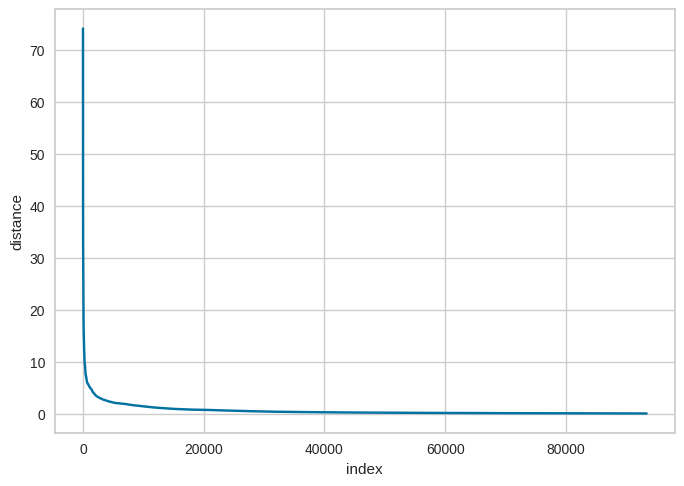

In [10]:
dfwip_withreduc.sort_values(by=['knn_point_leplus_eloigne'], ascending=False).reset_index()['knn_point_leplus_eloigne'].plot()
plt.xlabel("index")
plt.ylabel("distance")
plt.grid(True)
plt.show()

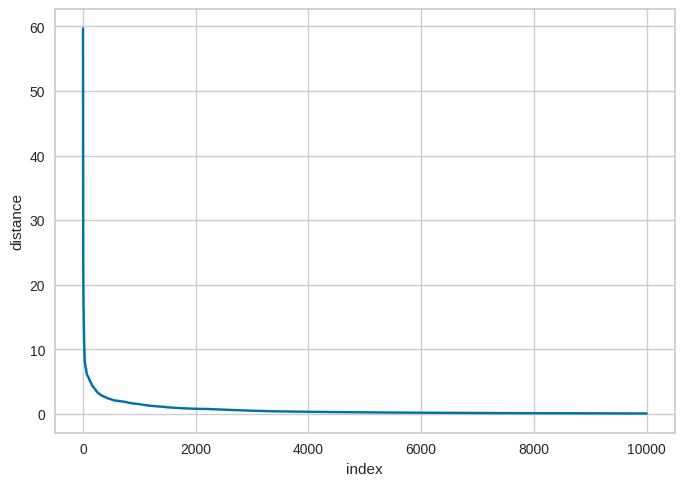

In [11]:
dfwip_withreduc.iloc[:10_000, :].sort_values(by=['knn_point_leplus_eloigne'], ascending=False).reset_index()['knn_point_leplus_eloigne'].plot()
plt.xlabel("index")
plt.ylabel("distance")
plt.grid(True)
plt.show()

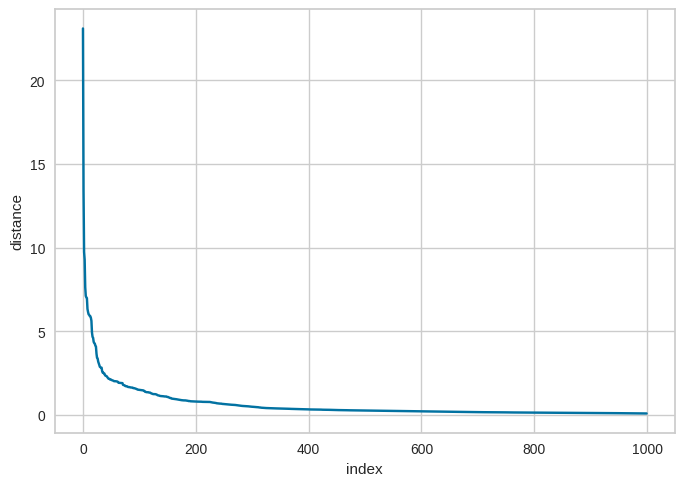

In [12]:
dfwip_withreduc.iloc[:1_000, :].sort_values(by=['knn_point_leplus_eloigne'], ascending=False).reset_index()['knn_point_leplus_eloigne'].plot()
plt.xlabel("index")
plt.ylabel("distance")
plt.grid(True)
plt.show()

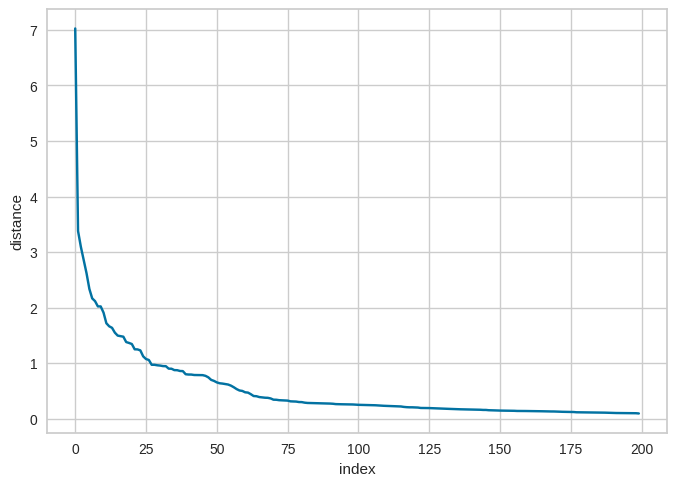

In [13]:
dfwip_withreduc.iloc[:200, :].sort_values(by=['knn_point_leplus_eloigne'], ascending=False).reset_index()['knn_point_leplus_eloigne'].plot()
plt.xlabel("index")
plt.ylabel("distance")
plt.grid(True)
plt.show()

On On va opter pour epsilon = 1 qui semble etre le coude de notre courbe.

### 1.2. Clusterisation

In [6]:
lblcol='dbscan_big_1'

dbs = DBSCAN(eps=1, min_samples=DB_MIN_SAMPLE)
dfwip_withreduc[lblcol] = dbs.fit_predict(X_scaled)

/tmp/ipykernel_6149/4122821512.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfwip_withreduc[lblcol] = dbs.fit_predict(X_scaled)


In [7]:
print("Nombre de clusters identifies : ", dfwip_withreduc[lblcol].nunique())
print("Nombre d'outliers : ", dfwip_withreduc[dfwip_withreduc[lblcol]==-1].shape[0])

Nombre de clusters identifies :  4
Nombre d'outliers :  10379


In [8]:
dfwip_withreduc[lblcol].value_counts(normalize=True)

dbscan_big_1
 0    0.826014
-1    0.111174
 1    0.049680
 2    0.013132
Name: proportion, dtype: float64

In [9]:
dfwip_withreduc[lblcol].value_counts(normalize=False)

dbscan_big_1
 0    77115
-1    10379
 1     4638
 2     1226
Name: count, dtype: int64

On obtient 4 clusters, ce qui paraît cohérent avec notre K-Means précédent. Cependant, 11% des points sont considérés comme des outliers. Et le cluster 0 contient plus de 82% pour du dataset. Ce sont nos clients lambda, mais cela offre assez peu de détails sur les pratiques de consommation.

In [10]:
ss_dbscan_big_eps1 = silhouette_score(X_scaled, dfwip_withreduc[lblcol])
print("Silhouette score incluant outliers : ", np.round(ss_dbscan_big_eps1, 2))

Silhouette score incluant outliers :  0.22


Pas top. Sachant que sur ce dataset avec notre K-Means, on arrivait presque a 0.4. Cependant, la manière dont sont traités les outliers avec DBSCAN peut vraiment nuire au résultat du silhouette score. Donc, pour information, on va calculer le silhouette score, une fois le df filtré de ses outliers.

In [11]:
tmpdf = dfwip_withreduc

output_lbl = tmpdf[tmpdf[lblcol]!=-1][lblcol]
tmpdf = tmpdf[tmpdf[lblcol]!=-1]
tmpdf_scaled = StandardScaler().fit_transform(tmpdf[['depense', 'nbcommandes', 'recence', 'avis_moyen', 'nb_items_moyen', 'reducs', 'montant_reducs']].values)

ss_dbscan_big_eps1_nooutlier = silhouette_score(tmpdf_scaled, output_lbl)
print("Silhouette score pour cette clusterisation (sans les outliers): ", np.round(ss_dbscan_big_eps1_nooutlier, 2))

Silhouette score pour cette clusterisation (sans les outliers):  0.51


### 1.3. Interprétation des résultats.

In [12]:
def create_radar_df(df, label_col, wr=True) : 
    dfres=df
    # recence 
    dfres['segments_Recence'] = pd.qcut(dfres['recence'], 6)
    dfres['note_Recence'] = pd.qcut(dfres['recence'], 6, labels=False)
    dfres.loc[dfres['note_Recence']==0, 'radar_Recence'] = 5
    dfres.loc[dfres['note_Recence']==1, 'radar_Recence'] = 4
    dfres.loc[dfres['note_Recence']==2, 'radar_Recence'] = 3
    dfres.loc[dfres['note_Recence']==3, 'radar_Recence'] = 2
    dfres.loc[dfres['note_Recence']==4, 'radar_Recence'] = 1
    dfres.loc[dfres['note_Recence']==5, 'radar_Recence'] = 0

    # depenses
    dfres['segments_Depense'] = pd.qcut(dfres['depense'], 6)
    dfres['note_Depense'] = pd.qcut(dfres['depense'], 6, labels=False)

    # nb items
    dfres['note_nbItems'] = 1
    dfres.loc[dfres['nb_items_moyen']==2, 'note_nbItems'] = 3
    dfres.loc[dfres['nb_items_moyen']>2, 'note_nbItems'] = 5

    # nb commandes
    dfres['note_nbCommandes'] = 1
    dfres.loc[dfres['nbcommandes']>1, 'note_nbCommandes'] = 5

    if wr :
        # reducs
        dfres['note_nbReducs'] = 0
        dfres.loc[dfres['reducs'] == 1, 'note_nbReducs'] = 2
        dfres.loc[dfres['reducs'] > 1, 'note_nbReducs'] = 5

        # Montant reduc
        dfres['note_montantReducs'] = 0
        dfres.loc[(dfres['montant_reducs'] > 0) & (dfres['montant_reducs'] < 100), 'note_montantReducs'] = 2
        dfres.loc[(dfres['montant_reducs'] > 0) & (dfres['montant_reducs'] >= 100), 'note_montantReducs'] = 5

        # Synthese
        radar_df = dfres[['radar_Recence', 'note_Depense', 'avis_moyen', 'note_nbItems', 'note_nbCommandes', 'note_montantReducs', label_col]]
        radar_df.rename(columns={'radar_Recence' : 'recence', 'note_Depense' : 'depenses', 
                            'avis_moyen' : 'Avis', 'note_nbItems' : 'Nb items', 
                            'note_nbCommandes' : 'nb commandes', 'note_montantReducs' : 'Reducs'}, inplace=True)
    else :
        # Synthese
        radar_df = dfres[['radar_Recence', 'note_Depense', 'avis_moyen', 'note_nbItems', 'note_nbCommandes', label_col]]
        radar_df.rename(columns={'radar_Recence' : 'recence', 'note_Depense' : 'depenses', 
                            'avis_moyen' : 'Avis', 'note_nbItems' : 'Nb items', 
                            'note_nbCommandes' : 'nb commandes'}, inplace=True)

    return radar_df

In [13]:
rdfb_eps1 = create_radar_df(df=dfwip_withreduc, label_col=lblcol)
rdfb_eps1.head(2)

/tmp/ipykernel_6149/2542888160.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfres['segments_Recence'] = pd.qcut(dfres['recence'], 6)
/tmp/ipykernel_6149/2542888160.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfres['note_Recence'] = pd.qcut(dfres['recence'], 6, labels=False)
/tmp/ipykernel_6149/2542888160.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation

recence  depenses  Avis  Nb items  nb commandes  Reducs  dbscan_big_1
0      4.0         3   5.0         1             1       0             0
1      4.0         0   4.0         1             1       0             0

In [14]:
categories = rdfb_eps1.drop(columns=[lblcol]).columns

fig = go.Figure()

for lbl in rdfb_eps1[lblcol].unique() : 
    cluster_df = rdfb_eps1[rdfb_eps1[lblcol] == lbl].drop(columns=[lblcol])
    cluster_means = cluster_df.mean().reset_index()
    fig.add_trace(go.Scatterpolar(
      r=cluster_means[0],
      theta=categories,
      fill='toself',
      name=f'Cluster{lbl}'
    ))

fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=[0, 5]
    ),
  ),
  showlegend=True
)

fig.show()

De manière assez étonnante, aucun cluster ne se distingue vraiment par l'usage de reduction, si ce n'est les "outliers" qui semblent être les seuls à en utiliser. Ce sont aussi ceux qui commandent le plus regulierement.

In [15]:
cv810.radar_2_a_2(df = rdfb_eps1, 
                  categories = categories, 
                  label_var = lblcol, 
                  value1 = 0, 
                  value2 = 1, 
                  legend_val1 = "82% du ds", 
                  legend_val2= "5% du ds")

Les 5% identifiés par DBSCAN sont des clients qui ne dépensent pas autaut que les "fortunés" ou que les "MVC" qu'avait isolé K-means, mais qui dépensent un peu plus que la moyenne, notamment parce qu'ils ont tendance à acheter plus d'items.

La masse, elle, est constituée de personnes qui ont fait une fois, une commande, qui depensent peu et sont plutôt satisfaites.

In [16]:
cv810.radar_2_a_2(df = rdfb_eps1, 
                  categories = categories, 
                  label_var = lblcol, 
                  value1 = 2, 
                  value2 = -1, 
                  legend_val1 = "1% du ds", 
                  legend_val2= "outliers")

Les outliers sont des gens plutot satisfaits, qui dépensent un peu plus que la moyenne, sur un seul item, en utilisant en général une reduction. Ils ont tendance a passer plusieurs commandes.

La categorie 2 achète plusieurs items en une commandes mais est très peu satisfaite. En même temps, acheter plusieurs Items sur une _market place_ signifie parfois "plusieurs revendeurs", donc des délais de livraisons variant pour les articles d'une même commande (ce qui peut nuire au service).

In [17]:
df_tosave = df
df_tosave['dbs_big_eps1'] = rdfb_eps1[lblcol]
df_tosave.head(2)

client  depense  nbcommandes  recence  \
0  0000366f3b9a7992bf8c76cfdf3221e2   141.90            1      111   
1  0000b849f77a49e4a4ce2b2a4ca5be3f    27.19            1      114   

   avis_moyen  nb_items_moyen  reducs  montant_reducs  \
0         5.0             1.0     0.0             0.0   
1         4.0             1.0     0.0             0.0   

  categorie_produit_preferee  big_k4_label  ...  note_Recence  radar_Recence  \
0             bed_bath_table             0  ...             1            4.0   
1              health_beauty             0  ...             1            4.0   

   segments_Depense note_Depense  note_nbItems  note_nbCommandes  \
0  (107.78, 151.78]            3             1                 1   
1     (9.589, 50.1]            0             1                 1   

  note_nbReducs  note_montantReducs  catcusto_k7s  dbs_big_eps1  
0             0                   0   A réactiver             0  
1             0                   0   A réactiver             0  

[2 rows x 24 columns]

## 2. Dataframe _sans_ les réductions
### 2.1. Recherche des meilleurs hyperparamètres

In [18]:
dfwip_sansreduc = df[['depense', 'nbcommandes', 'recence', 'avis_moyen', 'nb_items_moyen']]
DB_MIN_SAMPLE = int(dfwip_sansreduc.shape[0]*0.01) # 1% de nos observations
X = dfwip_sansreduc.values
X_scaled = StandardScaler().fit_transform(X)

In [19]:
nghbrs = NearestNeighbors(n_neighbors=DB_MIN_SAMPLE).fit(X_scaled) # Helas, plus notre DB_MIN est grand, plus les temps de calculs sont longs
distances, indices = nghbrs.kneighbors(X_scaled)

In [20]:
print("min samples : ", DB_MIN_SAMPLE)
print("Shape of distance matrix : ", distances.shape)

min samples :  933
Shape of distance matrix :  (93358, 933)


In [21]:
dfwip_sansreduc['knn_point_leplus_eloigne'] = distances[:, -1]
dfwip_sansreduc.head(2)

/tmp/ipykernel_6149/694147938.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



depense  nbcommandes  recence  avis_moyen  nb_items_moyen  \
0   141.90            1      111         5.0             1.0   
1    27.19            1      114         4.0             1.0   

   knn_point_leplus_eloigne  
0                  0.143090  
1                  0.252731

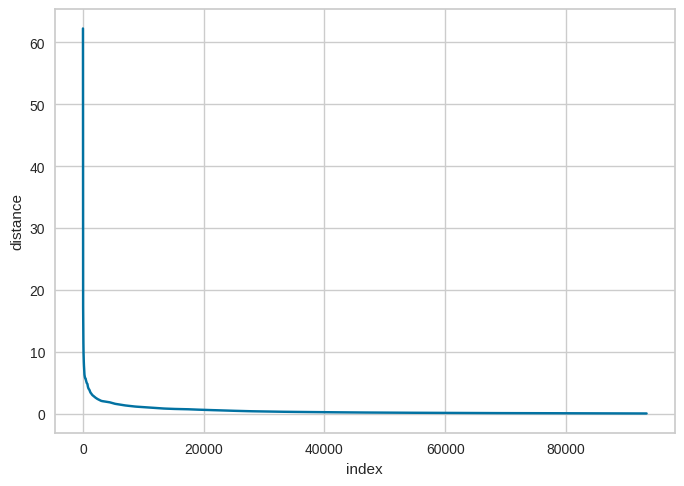

In [22]:
dfwip_sansreduc.sort_values(by=['knn_point_leplus_eloigne'], ascending=False).reset_index()['knn_point_leplus_eloigne'].plot()
plt.xlabel("index")
plt.ylabel("distance")
plt.grid(True)
plt.show()

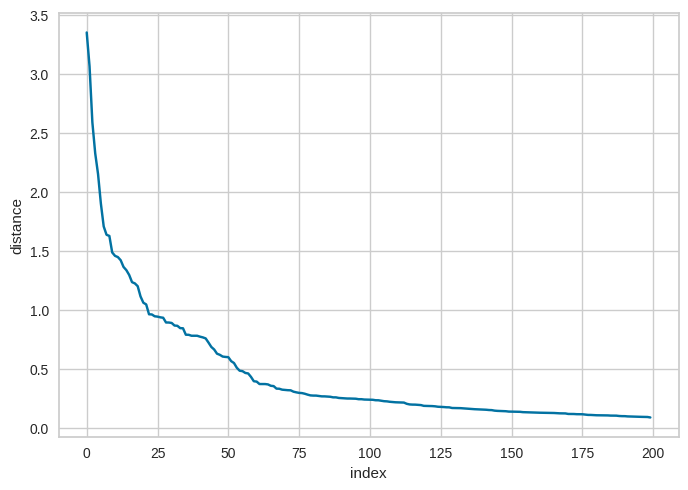

In [23]:
dfwip_sansreduc.iloc[:200, :].sort_values(by=['knn_point_leplus_eloigne'], ascending=False).reset_index()['knn_point_leplus_eloigne'].plot()
plt.xlabel("index")
plt.ylabel("distance")
plt.grid(True)
plt.show()

### 2.2. Clusterisation

In [24]:
lblcol = 'dbscan_small_1'
dbs = DBSCAN(eps=1, min_samples=DB_MIN_SAMPLE)
dfwip_sansreduc[lblcol] = dbs.fit_predict(X_scaled)

/tmp/ipykernel_6149/2436083661.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [25]:
print("Nombre de clusters identifies : ", dfwip_sansreduc[lblcol].nunique())
print("Nombre d'outliers : ", dfwip_sansreduc[dfwip_sansreduc[lblcol]==-1].shape[0])

Nombre de clusters identifies :  4
Nombre d'outliers :  7031


In [26]:
dfwip_sansreduc[lblcol].value_counts(normalize=True)

dbscan_small_1
 0    0.859134
-1    0.075312
 1    0.051329
 2    0.014225
Name: proportion, dtype: float64

In [27]:
dfwip_sansreduc[lblcol].value_counts(normalize=False)

dbscan_small_1
 0    80207
-1     7031
 1     4792
 2     1328
Name: count, dtype: int64

In [28]:
ss_dbscan_small_eps1 = silhouette_score(X_scaled, dfwip_sansreduc[lblcol])
print("Silhouette score incluant outliers : ", np.round(ss_dbscan_small_eps1, 2))

Silhouette score incluant outliers :  0.25


In [29]:
tmpdf = dfwip_sansreduc

output_lbl = tmpdf[tmpdf[lblcol]!=-1][lblcol]
tmpdf = tmpdf[tmpdf[lblcol]!=-1]
tmpdf_scaled = StandardScaler().fit_transform(tmpdf[['depense', 'nbcommandes', 'recence', 'avis_moyen', 'nb_items_moyen']].values)

ss_dbscan_small_eps1_nooutlier = silhouette_score(tmpdf_scaled, output_lbl)
print("Silhouette score pour cette clusterisation (sans les outliers): ", np.round(ss_dbscan_small_eps1_nooutlier, 2))

Silhouette score pour cette clusterisation (sans les outliers):  0.51


Les resultats sont un peu meilleurs que pour le dataset incluant les _vouchers_, mais sans plus.

### 2.3. Étude des résultats

In [30]:
rdfs_eps1 = create_radar_df(df=dfwip_sansreduc, label_col=lblcol, wr=False)
rdfs_eps1.head(2)

/tmp/ipykernel_6149/2542888160.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_6149/2542888160.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_6149/2542888160.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_6149

recence  depenses  Avis  Nb items  nb commandes  dbscan_small_1
0      4.0         3   5.0         1             1               0
1      4.0         0   4.0         1             1               0

In [31]:
dfr = rdfs_eps1
categories = dfr.drop(columns=[lblcol]).columns

fig = go.Figure()

for lbl in dfr[lblcol].unique() : 
    cluster_df = dfr[dfr[lblcol] == lbl].drop(columns=[lblcol])
    cluster_means = cluster_df.mean().reset_index()
    fig.add_trace(go.Scatterpolar(
      r=cluster_means[0],
      theta=categories,
      fill='toself',
      name=f'Cluster{lbl}'
    ))

fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=[0, 5]
    ),
  ),
  showlegend=True
)

fig.show()

In [32]:
cv810.radar_2_a_2(df = dfr, 
                  categories = categories, 
                  label_var = lblcol, 
                  value1 = 0, 
                  value2 = 1, 
                  legend_val1 = "Cluster 0", 
                  legend_val2= "Cluster 1")

Le cluster 0, c'est la masse des clients, quelle que soit leur récence.
Le 1 c'est un mélange des gros et moyens paniers : Ils depensent bien plus qu'un client lambda, notamment parce qu'ils achetent plus d'items.

In [33]:
cv810.radar_2_a_2(df = dfr, 
                  categories = categories, 
                  label_var = lblcol, 
                  value1 = 2, 
                  value2 = -1, 
                  legend_val1 = "1% du ds", 
                  legend_val2= "outliers")

Le cluster 2, ce sont les personnes qui ont des gros paniers et ne sont pas satisfaites. Les outliers semblent contenir MVC et fortunes. Il y a une certaine coherence a ce que des clients reguliers, pour un business de marketplace soient consideres comme des outliers. Car ils tiennent probablement du cas particulier qui pourraient autrement se rattacher a d'autres clusters

In [34]:
cv810.radar_2_a_2(df = dfr, 
                  categories = categories, 
                  label_var = lblcol, 
                  value1 = 1, 
                  value2 = 2, 
                  legend_val1 = "5% du ds (cat. 1)", 
                  legend_val2= "1% du ds (cat. 2)")

Quelque soit le dataset de travail, DBSCAN met en valeur deux categories distinctes : 
1. Les personnes qui ont fait une commande de plusieurs items et qui sont tres satisfaites.
2. Les personnes qui ont fait une commande de plusieurs items et qui sont peu satisfaites.

In [35]:
df_tosave['dbs_small_eps1'] = dfr[lblcol]
df_tosave.head(2)

client  depense  nbcommandes  recence  \
0  0000366f3b9a7992bf8c76cfdf3221e2   141.90            1      111   
1  0000b849f77a49e4a4ce2b2a4ca5be3f    27.19            1      114   

   avis_moyen  nb_items_moyen  reducs  montant_reducs  \
0         5.0             1.0     0.0             0.0   
1         4.0             1.0     0.0             0.0   

  categorie_produit_preferee  big_k4_label  ...  radar_Recence  \
0             bed_bath_table             0  ...            4.0   
1              health_beauty             0  ...            4.0   

   segments_Depense  note_Depense note_nbItems  note_nbCommandes  \
0  (107.78, 151.78]             3            1                 1   
1     (9.589, 50.1]             0            1                 1   

   note_nbReducs note_montantReducs  catcusto_k7s  dbs_big_eps1  \
0              0                  0   A réactiver             0   
1              0                  0   A réactiver             0   

   dbs_small_eps1  
0               0  
1               0  

[2 rows x 25 columns]

In [37]:
date_of_birth = dt.date.today()
df.to_csv('./model_results/kmeans_'+date_of_birth.strftime("%Y%m%d")+'_labeled_plusDBscan.csv', index=False)

-------------------------------------------------------

# CAH

In [38]:
df = pd.read_csv('./model_results/kmeans_20230821_labeled_plusDBscan.csv')
df.head(2)

client  depense  nbcommandes  recence  \
0  0000366f3b9a7992bf8c76cfdf3221e2   141.90            1      111   
1  0000b849f77a49e4a4ce2b2a4ca5be3f    27.19            1      114   

   avis_moyen  nb_items_moyen  reducs  montant_reducs  \
0         5.0             1.0     0.0             0.0   
1         4.0             1.0     0.0             0.0   

  categorie_produit_preferee  big_k4_label  ...  radar_Recence  \
0             bed_bath_table             0  ...            4.0   
1              health_beauty             0  ...            4.0   

   segments_Depense  note_Depense note_nbItems  note_nbCommandes  \
0  (107.78, 151.78]             3            1                 1   
1     (9.589, 50.1]             0            1                 1   

   note_nbReducs note_montantReducs  catcusto_k7s  dbs_big_eps1  \
0              0                  0   A réactiver             0   
1              0                  0   A réactiver             0   

   dbs_small_eps1  
0               0  
1               0  

[2 rows x 25 columns]

__Je vais travailler avec un échantillon de données sinon mon Kernel crashe ; que j'utilise VS Code ou Jupyter Lab classique__ (voir dossier images)

([Lien](https://github.com/microsoft/vscode-jupyter/wiki/Kernel-crashes) imprecrans du message d'erreur.)

In [40]:
df_sample = df.sample(n=20_000, random_state=1)
df_sample['small_k7_label'].value_counts(normalize=True)

small_k7_label
0    0.41705
2    0.31320
4    0.15180
5    0.06480
3    0.02805
6    0.01670
1    0.00840
Name: proportion, dtype: float64

Les proportions des différents clusters du K-Means pour k=7 sont maintenues, notre échantillon est représentatif du dataset.

In [41]:
df_wr = df_sample[['depense', 'nbcommandes', 'recence', 'avis_moyen', 'nb_items_moyen', 'reducs', 'montant_reducs']]
X = df_wr.values
X_scaled = StandardScaler().fit_transform(X)

## Test _avec_ variables liées aux réductions
### n_clusters = 4

In [42]:
cah = AgglomerativeClustering(n_clusters=4,
                              metric='euclidean',
                              linkage='ward')
cah.fit(X_scaled)

AgglomerativeClustering(metric='euclidean', n_clusters=4)

In [43]:
df_sample['cah_4_labels'] = cah.labels_
df_sample['cah_4_labels'].value_counts(normalize=True)

cah_4_labels
0    0.75240
1    0.18315
3    0.03665
2    0.02780
Name: proportion, dtype: float64

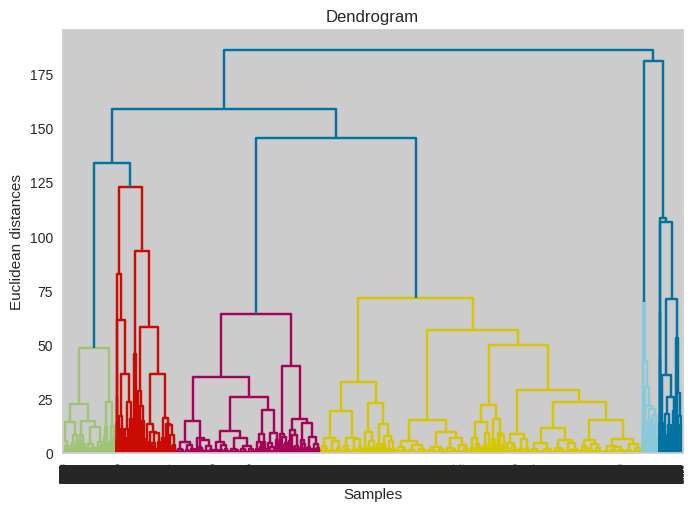

In [44]:
sch.dendrogram(sch.linkage(X_scaled, method='ward'))
plt.title('Dendrogram')
plt.xlabel('Samples')
plt.ylabel('Euclidean distances')
plt.show()

En fonction de la distance souhaitée, on peut essayer de définir 4 ou 6 clusters.

In [45]:
lblcol = 'cah_4_labels'
cah_k4 = create_radar_df(df=df_sample, label_col=lblcol, wr=True)

/tmp/ipykernel_6149/2542888160.py:39: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [46]:
dfr = cah_k4
categories = dfr.drop(columns=[lblcol]).columns

fig = go.Figure()

for lbl in dfr[lblcol].unique() : 
    cluster_df = dfr[dfr[lblcol] == lbl].drop(columns=[lblcol])
    cluster_means = cluster_df.mean().reset_index()
    fig.add_trace(go.Scatterpolar(
      r=cluster_means[0],
      theta=categories,
      fill='toself',
      name=f'Cluster{lbl}'
    ))

fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=[0, 5]
    ),
  ),
  showlegend=True
)

fig.show()

On retrouve quelques catégories que nous commençons à être habitués à voir :
- La masse plutot satisfaite de clients (75%)
- Ceux qui dépensent un peu plus, pour un peu plus d'articles mais qui sont moins satisfaits (18%)
- Les MVC (2.7% de l'échantillon) qui commandent régulièrement (donc ont dépensé beaucoup) (2.7%)
- Enfin le dernier groupe correspond bien aux couponneurs (3.6%)

In [47]:
ss_cah_4 = silhouette_score(X_scaled, df_sample[lblcol])
print("Silhouette score CAH (k=4 + reductions) : ", np.round(ss_cah_4, 2))

Silhouette score CAH (k=4 + reductions) :  0.41


C'est plutôt bon, par rapport à nos modèles précédents, mais le problème du CAH réside dans sa consommation de ressources.

## Test _sans_ variables liées aux réductions
### n_clusters = 6

In [48]:
df_or = df_sample[['depense', 'nbcommandes', 'recence', 'avis_moyen', 'nb_items_moyen']]
X = df_or.values
X_scaled = StandardScaler().fit_transform(X)

In [49]:
cah = AgglomerativeClustering(n_clusters=6,
                              metric='euclidean',
                              linkage='ward')
cah.fit(X_scaled)

AgglomerativeClustering(metric='euclidean', n_clusters=6)

In [50]:
df_sample['cah_s6_labels'] = cah.labels_
df_sample['cah_s6_labels'].value_counts(normalize=True)

cah_s6_labels
2    0.57710
4    0.20440
3    0.11460
0    0.06765
1    0.02815
5    0.00810
Name: proportion, dtype: float64

In [51]:
lblcol = 'cah_s6_labels'
cah_sk6 = create_radar_df(df=df_sample, label_col=lblcol, wr=False)

/tmp/ipykernel_6149/2542888160.py:45: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [52]:
dfr = cah_sk6
categories = dfr.drop(columns=[lblcol]).columns

fig = go.Figure()

for lbl in dfr[lblcol].unique() : 
    cluster_df = dfr[dfr[lblcol] == lbl].drop(columns=[lblcol])
    cluster_means = cluster_df.mean().reset_index()
    fig.add_trace(go.Scatterpolar(
      r=cluster_means[0],
      theta=categories,
      fill='toself',
      name=f'Cluster{lbl}'
    ))

fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=[0, 5]
    ),
  ),
  showlegend=True
)

fig.show()

In [53]:
ss_cah_sk6 = silhouette_score(X_scaled, df_sample[lblcol])
print("Silhouette score CAH (k=6 + reductions) : ", np.round(ss_cah_sk6, 2))

Silhouette score CAH (k=6 + reductions) :  0.35


- Le cluster 1 correspond à nos MVC, ceux qui reviennent régulièrement.
- Le 5 a nos très fortunés
- etc.


En somme, le CAH ne permet pas de mettre en avant de nouvelles catégories, son silhouet score n'est pas remarquablement meilleur que celui des autres algorithmes, et son execution sur tout le dataset lance des exceptions. On ne va donc pas plus creuser cette piste.

------------------------------------

# t-SNE pour visualisation des clusters

In [56]:
df = pd.read_csv('./model_results/kmeans_20230818_labeled.csv')
df.head(2)

client  depense  nbcommandes  recence  \
0  0000366f3b9a7992bf8c76cfdf3221e2   141.90            1      111   
1  0000b849f77a49e4a4ce2b2a4ca5be3f    27.19            1      114   

   avis_moyen  nb_items_moyen  reducs  montant_reducs  \
0         5.0             1.0     0.0             0.0   
1         4.0             1.0     0.0             0.0   

  categorie_produit_preferee  big_k4_label  ...  segments_Recence  \
0             bed_bath_table             0  ...     (75.0, 148.0]   
1              health_beauty             0  ...     (75.0, 148.0]   

   note_Recence  radar_Recence  segments_Depense  note_Depense  note_nbItems  \
0             1            4.0  (107.78, 151.78]             3             1   
1             1            4.0     (9.589, 50.1]             0             1   

  note_nbCommandes  note_nbReducs  note_montantReducs  catcusto_k7s  
0                1              0                   0   A réactiver  
1                1              0                   0   A réactiver  

[2 rows x 23 columns]

In [57]:
dw = df[['depense', 'nbcommandes', 'recence', 'avis_moyen', 'nb_items_moyen']]

In [58]:
X = dw
X_scaled = StandardScaler().fit_transform(X)

In [59]:
tsne = manifold.TSNE(n_components=2, init='pca')
X_trans = tsne.fit_transform(X_scaled)

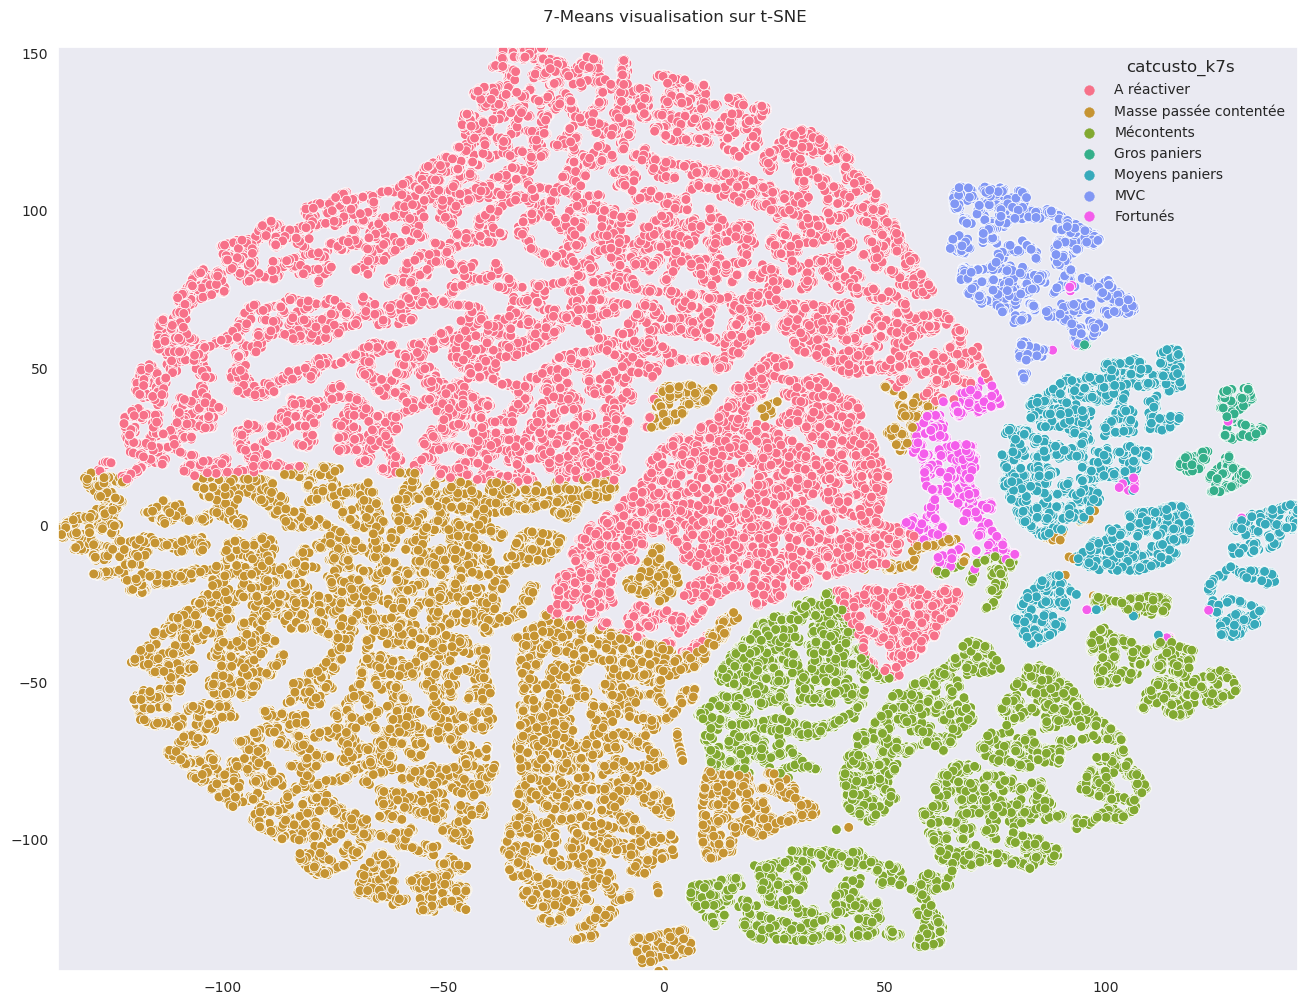

In [60]:
plt.figure(figsize=(16, 12))
sns.set_style("dark")
sns.scatterplot(x=X_trans[:, 0], y=X_trans[:, 1], hue=df['catcusto_k7s'])
    
# On redéfinit les axes pour bien voir tous les points
plt.xlim([np.min(X_trans[:, 0]), np.max(X_trans[:, 0])])
plt.ylim([np.min(X_trans[:, 1]), np.max(X_trans[:, 1])])

plt.title("7-Means visualisation sur t-SNE \n")

# On affiche l'image
plt.show()

On voit quelques points fushia apparaître au sein d'autres clusters. On dispose de personnes qui font de grosses dépenses dans d'autres clusters.

Pour voir s'ils peuvent etre considérés comme des outliers, je vais colorer les outliers du clustering (silhouette coef negatif)

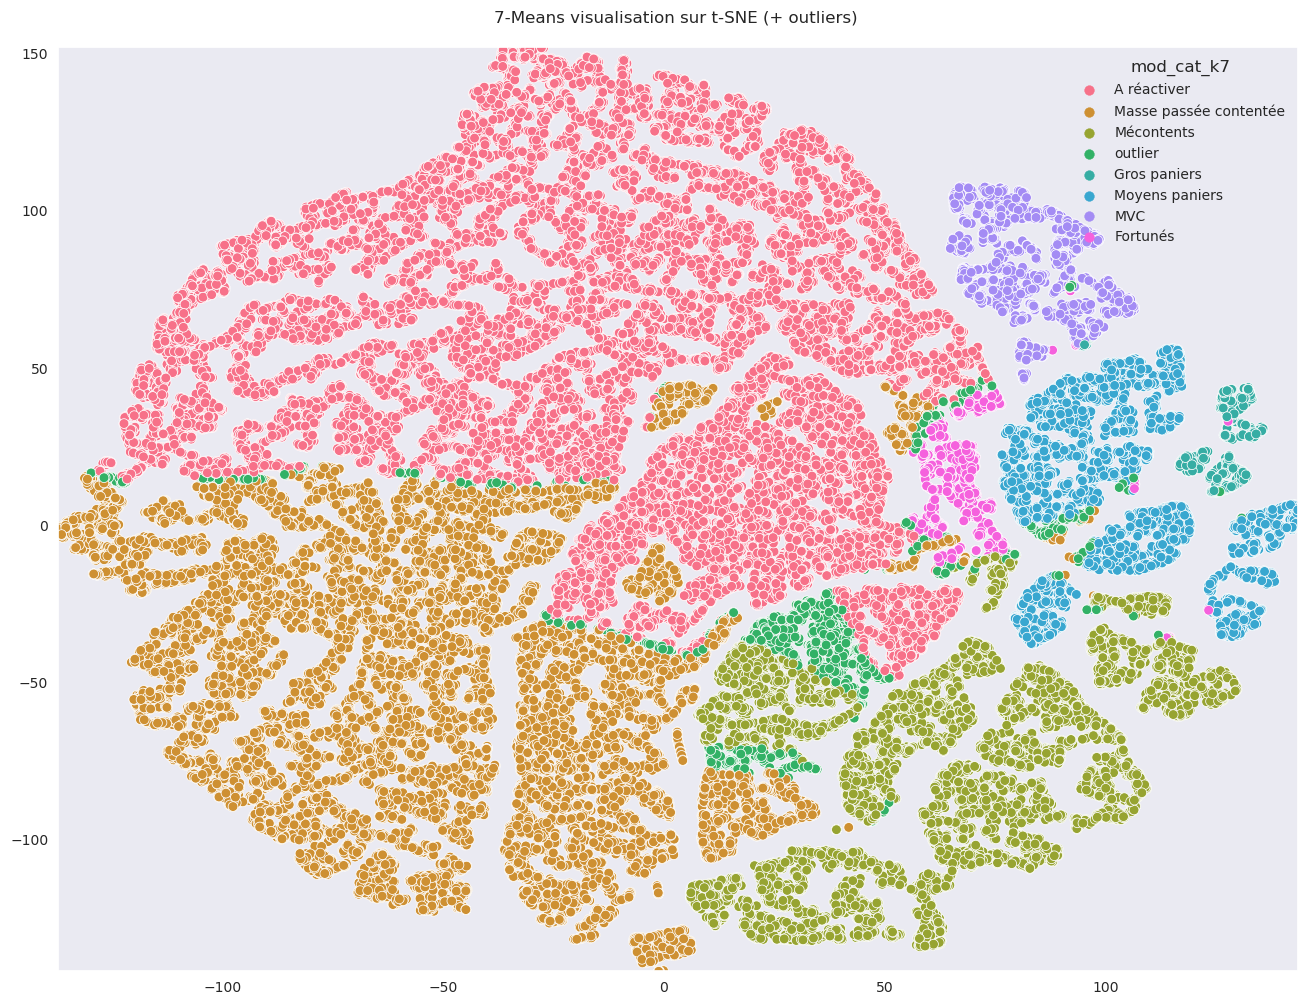

In [61]:
df.loc[:, 'mod_cat_k7'] = df['catcusto_k7s']
df.loc[df['small_k7_is_outlier'] == 1, 'mod_cat_k7'] = 'outlier'
plt.figure(figsize=(16, 12))
sns.set_style("dark")
sns.scatterplot(x=X_trans[:, 0], y=X_trans[:, 1], hue=df['mod_cat_k7'])
    
# On redéfinit les axes pour bien voir tous les points
plt.xlim([np.min(X_trans[:, 0]), np.max(X_trans[:, 0])])
plt.ylim([np.min(X_trans[:, 1]), np.max(X_trans[:, 1])])

plt.title("7-Means visualisation sur t-SNE (+ outliers) \n")

# On affiche l'image
plt.show()

La plupart des outliers résident aux frontières des clusters. On voit des zones de concentration au niveau des "mécontents" et de nos deux zones principales ("à réactiver" et "la masse passée contentée"). J'imagine qu'un client moyen qui met une note de 3/5 suite à sa commande peut facilement être à la frontière de ces zones. On pourrait le vérifier en observant la note moyenne de ces outliers, ou des outliers de manière générale.

Ce qui est intéressant c'est qu'il reste quelques points roses, nos "fortunés", au milieu des moyens paniers et des MVC. On en trouve même un parmis les mécontents.

# Conclusion

L'etude des differents modeles de clusterisation met en valeurs des categories recurrentes :
- Nos rares client reguliers
- Notre masse plutot satisfaite, qui peut parfois etre subdivisee en fonction de la recence des clients
- Des clients qui achetent plusieurs articles
- etc.

L'etude des differents modeles permet donc en soi de mieux connaitre sa clientele. Grace a ces informations, on pourrait imaginer deployer une strategie de communication ad hoc.

Pour des raisons de facilite d'interpretation, de precision des clusters ou encore de consommation de ressources pour la clusterisation, nous recommandons d'utiliser une clusterisation de type K-Means avec K=7, sur le dataset sans vouchers.

On peut maintenir un suivi, a part, de la categorie des couponneurs si nous souhaitons pouvoir les reactiver au besoin.

Dans le prochain fichier, nous tenterons d'estimer un plan de maintenance realiste des clusters en etudiant l'evolution de l'ARI du modele avec le temps.